## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration using chessboard images

(720, 1280, 3)


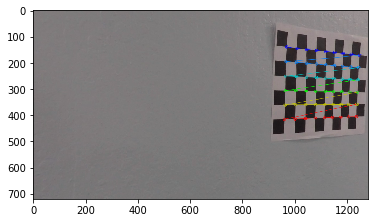

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #plt.imshow(img)
        #cv2.waitKey(500)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
undst = cv2.undistort(img, mtx, dist, None, mtx)
print(undst.shape)
plt.imshow(undst)
#cv2.destroyAllWindows()

True

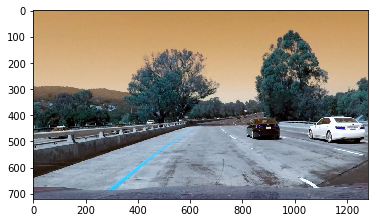

In [2]:
i='../test_images/test1.jpg'
img= cv2.imread(i)
undst = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(img)
cv2.imwrite('undst.jpg',undst)

# Line Class

In [3]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        #self.diffs = np.array([0,0,0], dtype='float')
        self.diffs = [np.array([0,0,0], dtype='float')]
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

#  Edge detection Pipeline

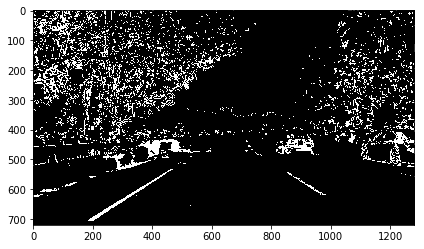

In [4]:



def abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100):
	"""
	Takes an image, gradient orientation, and threshold min/max values
	"""
	# Convert to grayscale
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	# Apply x or y gradient with Sobel function
	# and take the absolute value
	if orient == 'x':
		abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
	if orient == 'y':
		abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
	# Rescale back to 8 bit integer
	scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
	# Create a copy and apply the threshold
	binary_output = np.zeros_like(scaled_sobel)
	binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

	return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100)):
	"""
	Return the magnitude of the gradient
	for a given sobel kernel size and threshold values
	"""
	# Convert to grayscale
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	# Take both Sobel x and y gradients
	sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
	sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
	# Calculate the gradient magnitude
	grad_mag = np.sqrt(sobelx**2 + sobely**2)
	# Rescale to 8 bit
	scale_factor = np.max(grad_mag)/255
	grad_mag = (grad_mag/scale_factor).astype(np.uint8)
	# Create a binary image of ones where threshold is met, zeros otherwise
	binary_output = np.zeros_like(grad_mag)
	binary_output[(grad_mag >= mag_thresh[0]) & (grad_mag <= mag_thresh[1])] = 1

	# Return the binary image
	return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
	"""
	Return the direction of the gradient
	for a given sobel kernel size and threshold values
	"""
	# Convert to grayscale
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	# Calculate the x and y gradients
	sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
	sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
	# Take the absolute value of the gradient direction,
	# apply a threshold, and create a binary image result
	abs_dir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
	binary_output =  np.zeros_like(abs_dir)
	binary_output[(abs_dir >= thresh[0]) & (abs_dir <= thresh[1])] = 1

	# Return the binary image
	return binary_output


def hls_thresh(img, thresh=(100, 255)):
	"""
	Convert RGB to HLS and threshold to binary image using S channel
	"""
	hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
	s_channel = hls[:,:,2]
	binary_output = np.zeros_like(s_channel)
	binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
	return binary_output


def combined_thresh(img):
	abs_bin = abs_sobel_thresh(img, orient='x', thresh_min=50, thresh_max=255)
	mag_bin = mag_thresh(img, sobel_kernel=3, mag_thresh=(50, 255))
	dir_bin = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
	hls_bin = hls_thresh(img, thresh=(170, 255))

	combined = np.zeros_like(dir_bin)
	combined[(abs_bin == 1 | ((mag_bin == 1) & (dir_bin == 1))) | hls_bin == 1] = 1

	return combined  # DEBUG


img_file = '../test_images/straight_lines1.jpg'
img_file = '../test_images/test5.jpg'



img = mpimg.imread(img_file)
img = cv2.undistort(img, mtx, dist, None, mtx)

combined= combined_thresh(img)


plt.imshow(combined, cmap='gray', vmin=0, vmax=1)
cv2.imwrite('binary.png',combined)
plt.tight_layout()
plt.show()

# Finding Lane pixels

In [5]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    #print(nonzerox)
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        

        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
       
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    print(nonzerox[left_lane_inds])
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img





# Function to fit polynomial of 2nd degree

In [6]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty




# Search From Prior

In [7]:


def search_around_poly(binary_warped,left_fit , right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    # Draw the lane onto the warped blank image 
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return left_fitx,right_fitx,ploty


# Image pipeline

In [8]:
def pipeline_lane(image,l_line,r_line):
    
    
    undst = cv2.undistort(image, mtx, dist, None, mtx) # undistort the current frame
    
    warped = cv2.warpPerspective(undst,M,(undst.shape[1],undst.shape[0]),flags=cv2.INTER_NEAREST) #perstective tranformation for the bird eye view
    
    result = combined_thresh(warped)  #identiy edges in the image using the combined threshold technique

    global frame # global frame variable to record the frame count


    #print(frame)

    leftx, lefty, rightx, righty, out_img = find_lane_pixels(result) # find out the lane pixels 
    
    left_fitx, right_fitx, ploty = fit_poly(result.shape, leftx, lefty, rightx, righty) #fit a ploynomial for the given x,y pixels
    

    
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)  # polynomial in the real world scale
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)# polynomial in the real world scale
    
    #l_line.best_fit = np.vstack([l_line.best_fit,left_fit_cr])
    #r_line.best_fit = np.vstack([r_line.best_fit,right_fit_cr])
    
    #l_lane.best_fit = np.average(left_lane.best_fit[-5:], axis = 0)




    
    y_eval = np.max(ploty)*ym_per_pix  # y variable for pixel y=720 
    y0 = 0  # y variable for pixel y=0
    y1 = y_eval/2   # y variable for pixel 360
    
    # Calculate the real world measurements for coresponding pixels values 
    # equations coresponds to 2nd degree poly
    
    a1=(left_fit_cr[0]*(y0*ym_per_pix)**2 + left_fit_cr[1]*y0*ym_per_pix + left_fit_cr[2])
    b1 =(right_fit_cr[0]*(y0*ym_per_pix)**2 + right_fit_cr[1]*(y0*ym_per_pix) + right_fit_cr[2])
    
    a2=(left_fit_cr[0]*(y1*ym_per_pix)**2 + left_fit_cr[1]*y1*ym_per_pix + left_fit_cr[2])
    b2 =(right_fit_cr[0]*(y1*ym_per_pix)**2 + right_fit_cr[1]*(y1*ym_per_pix) + right_fit_cr[2])

    a3=(left_fit_cr[0]*(y_eval*ym_per_pix)**2 + left_fit_cr[1]*y_eval*ym_per_pix + left_fit_cr[2])
    b3 =(right_fit_cr[0]*(y_eval*ym_per_pix)**2 + right_fit_cr[1]*(y_eval*ym_per_pix) + right_fit_cr[2])
    
    # calculate the lane width for different y values, used for sanity check later on 
    d1 = np.absolute(a1-b1) 
    d2 = np.absolute(a2-b2)
    d3 = np.absolute(a3-b3)
    
    d_mean = (d1 +d2 +d3 )/3.0  # mean of the 3 different lane widths
    
    # Calculate the slope of the left and right lane polynomial at different y values
    # slope equation coresponds to the 1st derivative of the 2nd degree ploy equation
    
    slope1_1 = 2*left_fit_cr[0]*(y1*ym_per_pix) + left_fit_cr[1]*ym_per_pix
    slope2_1 = 2*right_fit_cr[0]*(y1*ym_per_pix) + right_fit_cr[1]*ym_per_pix
    
    slope1_2 = 2*left_fit_cr[0]*(y0*ym_per_pix) + left_fit_cr[1]*ym_per_pix
    slope2_2 = 2*right_fit_cr[0]*(y0*ym_per_pix) + right_fit_cr[1]*ym_per_pix
    
    slope1_3 = 2*left_fit_cr[0]*(y_eval*ym_per_pix) + left_fit_cr[1]*ym_per_pix
    slope2_3 = 2*right_fit_cr[0]*(y_eval*ym_per_pix) + right_fit_cr[1]*ym_per_pix
   
    
    s_mean1 = (slope1_1 + slope1_2 + slope1_3)/3.0  # mean of the 3 different slope values at different y for the left poly
    s_mean2 = (slope2_1 + slope2_2 + slope2_3)/3.0  # mean of the 3 different slope values at different y for the right poly
    
    
    s_mean = abs(s_mean1 - s_mean2) # find the difference between the mean slopes of the 2 ploynomials
    
    ################# coefficent diff #############
    
    #print(left_fit_cr[0]-right_fit_cr[0])
    #print(left_fit_cr[1]-right_fit_cr[1])
    #print(left_fit_cr[2]-right_fit_cr[2])
    
    
    
    #print("s_mean:"+str(s_mean)) # debugging 
    #####################
    
    #parallel = False
 
    l_line.detected = False   #flag for whether line detected is good enough
    r_line.detected = False
    
    # we assume all the lines detected are Not good untill they pass the sanity test
    
    
    # sanity test :1) mean lane width(d_mean) should be within the given range
    # sanity test: 2) diffenence between the slopes of the 2  polynomials should be almost 0, since the 
    # polynomials are suppose to be parallel
    if( d_mean > 3.1 and d_mean < 4.2 and s_mean < 0.0099):   
        #parallel = True
        l_line.detected = True # flag for passing the test
        r_line.detected = True


    
    #the calculation of R_curve (radius of curvature) 
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5)/np.absolute(2*left_fit_cr[0])  ## Implement the calculation of the left line here
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])  
    #print(np.absolute(left_curverad - right_curverad))
  
    #print("d_mean:  " +str(d_mean)) # debug
    
    #check if line has passed the sanity test
    if (l_line.detected == True and r_line.detected == True ):
        
        l_line.recent_xfitted.append(left_fitx) # append the good pixels to the left line class
        r_line.recent_xfitted.append(right_fitx) # append the good pixels to the right line class

        l_line.radius_of_curvature =left_curverad  # equate the radius of curvature in real world scale
        r_line.radius_of_curvature =right_curverad

        l_line.current_fit=left_fit_cr  # equate the polynomial coefficients
        r_line.current_fit=right_fit_cr
        #print(l_line.current_fit)
        
        
        a3=(l_line.current_fit[0]*(y_eval*ym_per_pix)**2 + l_line.current_fit[1]*y_eval*ym_per_pix + l_line.current_fit[2])
        b3 =(r_line.current_fit[0]*(y_eval*ym_per_pix)**2 + r_line.current_fit[1]*(y_eval*ym_per_pix) + r_line.current_fit[2])
        c = (a3+b3) /2  # lane offset calculation
        c = c*xm_per_pix  # lane offset in real world scale
        #global l_c
        #l_c.append(c)
        l_line.line_base_pos = c



        if frame >2:
            # pixel wise sucessive polynomial coefficients
            l_line.diffs.append(np.absolute(l_line.current_fit[-1] - l_line.current_fit[-2]))
            r_line.diffs.append(np.absolute(r_line.current_fit[-1] - r_line.current_fit[-2]))

        l_line.allx = leftx # lane pixels
        r_line.ally = rightx
    
    warp_zero = np.zeros_like(result).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    #points for visualisation
    pts_left = np.array([np.transpose(np.vstack([(l_line.recent_xfitted)[-1], ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([r_line.recent_xfitted[-1], ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result_final = cv2.addWeighted(undst, 1, newwarp, 0.3, 0)

    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText1 = (10,100)
    bottomLeftCornerOfText2 = (900,100)
    bottomLeftCornerOfText3 = (600,100)
    bottomLeftCornerOfText4 = (10,640)



    fontScale              = 0.5
    fontColor              = (255,255,255)
    lineType               = 1

    cv2.putText(result_final,"Radius of curvature:"+str(l_line.radius_of_curvature)+"m", bottomLeftCornerOfText1, font, fontScale,fontColor,lineType)
    cv2.putText(result_final,"Lane Offset:"+str(l_line.line_base_pos)+"m", bottomLeftCornerOfText2, font, fontScale,fontColor,lineType)
    cv2.putText(result_final,"frame no:"+str(frame), bottomLeftCornerOfText4, font, fontScale,fontColor,lineType)
    frame = frame +1 # increment frame

    

    
    
    return result_final

# Perspective transform to Bird's eye view

In [9]:

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
src1 = np.array([[585,460],[203,720],[1127,720],[695,460]],dtype=np.float32)
dst = np.array([[320,0],[320,720],[960,720],[960,0]],dtype=np.float32)

M = cv2.getPerspectiveTransform(src1,dst) 
Minv = cv2.getPerspectiveTransform(dst,src1) 


# Main body

In [10]:

ym_per_pix = 30.0/720 # meters per pixel in y dimension
xm_per_pix = 3.7/640.0 # meters per pixel in x dimensio
frame=1 # frame number
if __name__ == '__main__':


    l_line = Line() # initialse line class instance
    r_line = Line()
    
    ym_per_pix = 30.0/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/640.0 # meters per pixel in x dimensio
    white_output = '../final_video.mp4'
    ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
    ## To do so add .subclip(start_second,end_second) to the end of the line below
    ## Where start_second and end_second are integer values representing the start and end of the subclip
    ## You may also uncomment the following line for a subclip of the first 5 seconds
    ##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
    clip1 = VideoFileClip('../project_video.mp4')
    #frame= frame +1
    white_clip = clip1.fl_image(lambda image: pipeline_lane(image,l_line,r_line))
    #frame= frame +1
    %time white_clip.write_videofile(white_output, audio=False)

[358 359 360 ..., 279 283 284]
[MoviePy] >>>> Building video ../final_video.mp4
[MoviePy] Writing video ../final_video.mp4


  0%|          | 1/1261 [00:00<07:49,  2.69it/s]

[358 359 360 ..., 279 283 284]


  0%|          | 2/1261 [00:00<07:56,  2.64it/s]

[359 360 361 ..., 278 279 283]


  0%|          | 3/1261 [00:01<07:53,  2.66it/s]

[361 362 363 ..., 273 278 279]


  0%|          | 4/1261 [00:01<07:45,  2.70it/s]

[362 363 364 ..., 273 278 279]


  0%|          | 5/1261 [00:01<07:42,  2.71it/s]

[363 364 365 ..., 273 278 279]


  0%|          | 6/1261 [00:02<07:40,  2.72it/s]

[365 366 367 ..., 267 272 273]


  1%|          | 7/1261 [00:02<07:43,  2.71it/s]

[366 367 368 ..., 267 268 273]


  1%|          | 8/1261 [00:02<07:45,  2.69it/s]

[367 368 369 ..., 268 272 273]


  1%|          | 9/1261 [00:03<07:41,  2.71it/s]

[366 367 368 ..., 267 268 273]


  1%|          | 10/1261 [00:03<07:40,  2.72it/s]

[365 366 367 ..., 263 267 268]


  1%|          | 11/1261 [00:04<07:44,  2.69it/s]

[366 367 368 ..., 262 263 268]


  1%|          | 12/1261 [00:04<07:44,  2.69it/s]

[363 364 365 ..., 252 257 258]


  1%|          | 13/1261 [00:04<07:51,  2.65it/s]

[362 363 364 ..., 252 257 262]


  1%|          | 14/1261 [00:05<07:53,  2.63it/s]

[293 294 295 ..., 257 258 262]


  1%|          | 15/1261 [00:05<07:50,  2.65it/s]

[363 364 365 ..., 258 262 263]


  1%|▏         | 16/1261 [00:05<07:47,  2.66it/s]

[365 366 367 ..., 257 262 263]


  1%|▏         | 17/1261 [00:06<07:46,  2.67it/s]

[362 363 364 ..., 257 258 262]


  1%|▏         | 18/1261 [00:06<07:44,  2.67it/s]

[362 363 364 ..., 256 257 262]


  2%|▏         | 19/1261 [00:07<07:42,  2.69it/s]

[362 363 364 ..., 251 257 262]


  2%|▏         | 20/1261 [00:07<07:37,  2.71it/s]

[361 362 363 ..., 252 257 258]


  2%|▏         | 21/1261 [00:07<07:39,  2.70it/s]

[360 361 362 ..., 252 257 258]


  2%|▏         | 22/1261 [00:08<07:34,  2.72it/s]

[357 358 359 ..., 247 251 252]


  2%|▏         | 23/1261 [00:08<07:38,  2.70it/s]

[352 353 354 ..., 246 247 252]


  2%|▏         | 24/1261 [00:08<07:39,  2.69it/s]

[353 354 355 ..., 247 251 252]


  2%|▏         | 25/1261 [00:09<07:47,  2.64it/s]

[352 353 354 ..., 251 252 257]


  2%|▏         | 26/1261 [00:09<07:43,  2.67it/s]

[349 350 351 ..., 247 251 252]


  2%|▏         | 27/1261 [00:10<07:40,  2.68it/s]

[282 283 284 ..., 247 251 252]


  2%|▏         | 28/1261 [00:10<07:38,  2.69it/s]

[344 345 346 ..., 242 246 247]


  2%|▏         | 29/1261 [00:10<07:34,  2.71it/s]

[343 344 345 ..., 246 247 252]


  2%|▏         | 30/1261 [00:11<07:35,  2.70it/s]

[343 344 345 ..., 246 251 252]


  2%|▏         | 31/1261 [00:11<07:29,  2.73it/s]

[345 346 347 ..., 251 252 257]


  3%|▎         | 32/1261 [00:11<07:30,  2.73it/s]

[347 348 349 ..., 250 251 257]


  3%|▎         | 33/1261 [00:12<07:26,  2.75it/s]

[346 347 348 ..., 252 257 258]


  3%|▎         | 34/1261 [00:12<07:26,  2.75it/s]

[348 349 350 ..., 252 257 258]


  3%|▎         | 35/1261 [00:12<07:27,  2.74it/s]

[350 351 352 ..., 252 257 258]


  3%|▎         | 36/1261 [00:13<07:26,  2.74it/s]

[352 353 354 ..., 252 257 258]


  3%|▎         | 37/1261 [00:13<07:25,  2.75it/s]

[353 354 355 ..., 252 257 258]


  3%|▎         | 38/1261 [00:14<07:33,  2.70it/s]

[355 356 357 ..., 252 257 258]


  3%|▎         | 39/1261 [00:14<07:30,  2.71it/s]

[290 291 294 ..., 252 257 258]


  3%|▎         | 40/1261 [00:14<07:28,  2.72it/s]

[356 357 358 ..., 247 251 252]


  3%|▎         | 41/1261 [00:15<07:26,  2.73it/s]

[356 357 358 ..., 247 251 252]


  3%|▎         | 42/1261 [00:15<07:24,  2.74it/s]

[357 358 359 ..., 241 246 247]


  3%|▎         | 43/1261 [00:16<08:54,  2.28it/s]

[358 359 360 ..., 241 242 247]


  3%|▎         | 44/1261 [00:16<08:52,  2.28it/s]

[357 358 359 ..., 236 241 242]


  4%|▎         | 45/1261 [00:17<09:09,  2.21it/s]

[357 358 359 ..., 235 236 241]


  4%|▎         | 46/1261 [00:17<09:11,  2.20it/s]

[357 358 359 ..., 236 237 241]


  4%|▎         | 47/1261 [00:17<08:55,  2.27it/s]

[356 357 358 ..., 236 237 241]


  4%|▍         | 48/1261 [00:18<08:56,  2.26it/s]

[357 358 359 ..., 236 237 241]


  4%|▍         | 49/1261 [00:18<08:43,  2.31it/s]

[356 357 358 ..., 230 231 236]


  4%|▍         | 50/1261 [00:19<08:56,  2.26it/s]

[356 357 358 ..., 230 231 236]


  4%|▍         | 51/1261 [00:19<08:47,  2.29it/s]

[356 357 358 ..., 230 231 236]


  4%|▍         | 52/1261 [00:20<08:57,  2.25it/s]

[286 287 288 ..., 231 236 241]


  4%|▍         | 53/1261 [00:20<08:49,  2.28it/s]

[357 358 359 ..., 236 237 241]


  4%|▍         | 54/1261 [00:21<09:01,  2.23it/s]

[356 357 358 ..., 230 236 241]


  4%|▍         | 55/1261 [00:21<08:53,  2.26it/s]

[356 357 358 ..., 229 230 236]


  4%|▍         | 56/1261 [00:21<08:59,  2.23it/s]

[354 355 356 ..., 229 230 236]


  5%|▍         | 57/1261 [00:22<09:23,  2.14it/s]

[354 355 356 ..., 229 230 236]


  5%|▍         | 58/1261 [00:22<09:17,  2.16it/s]

[353 354 355 ..., 236 237 241]


  5%|▍         | 59/1261 [00:23<09:11,  2.18it/s]

[354 355 356 ..., 241 242 247]


  5%|▍         | 60/1261 [00:23<09:08,  2.19it/s]

[354 355 356 ..., 242 246 247]


  5%|▍         | 61/1261 [00:24<09:03,  2.21it/s]

[352 353 354 ..., 246 247 252]


  5%|▍         | 62/1261 [00:24<08:59,  2.22it/s]

[352 353 354 ..., 247 251 252]


  5%|▍         | 63/1261 [00:25<08:58,  2.22it/s]

[350 351 352 ..., 246 247 252]


  5%|▌         | 64/1261 [00:25<08:57,  2.23it/s]

[350 351 352 ..., 251 252 257]


  5%|▌         | 65/1261 [00:26<08:53,  2.24it/s]

[347 348 349 ..., 247 251 252]


  5%|▌         | 66/1261 [00:26<08:49,  2.26it/s]

[347 348 349 ..., 241 247 252]


  5%|▌         | 67/1261 [00:26<08:56,  2.22it/s]

[346 347 348 ..., 241 247 252]


  5%|▌         | 68/1261 [00:27<08:54,  2.23it/s]

[343 344 345 ..., 239 240 241]


  5%|▌         | 69/1261 [00:27<08:55,  2.23it/s]

[343 344 345 ..., 245 246 252]


  6%|▌         | 70/1261 [00:28<08:54,  2.23it/s]

[342 343 344 ..., 241 247 252]


  6%|▌         | 71/1261 [00:28<09:09,  2.17it/s]

[342 343 344 ..., 252 257 258]


  6%|▌         | 72/1261 [00:29<09:02,  2.19it/s]

[341 342 343 ..., 246 247 252]


  6%|▌         | 73/1261 [00:29<09:04,  2.18it/s]

[340 341 342 ..., 241 247 252]


  6%|▌         | 74/1261 [00:30<09:00,  2.20it/s]

[341 342 343 ..., 246 247 252]


  6%|▌         | 75/1261 [00:30<09:01,  2.19it/s]

[339 340 341 ..., 236 241 247]


  6%|▌         | 76/1261 [00:31<08:49,  2.24it/s]

[339 340 341 ..., 240 241 247]


  6%|▌         | 77/1261 [00:31<08:55,  2.21it/s]

[274 275 278 ..., 235 236 241]


  6%|▌         | 78/1261 [00:31<08:40,  2.27it/s]

[337 338 339 ..., 216 220 241]


  6%|▋         | 79/1261 [00:32<08:54,  2.21it/s]

[334 335 336 ..., 229 230 241]


  6%|▋         | 80/1261 [00:32<08:43,  2.26it/s]

[333 334 335 ..., 228 229 230]


  6%|▋         | 81/1261 [00:33<08:59,  2.19it/s]

[332 333 334 ..., 234 235 236]


  7%|▋         | 82/1261 [00:33<08:45,  2.24it/s]

[329 330 331 ..., 234 235 236]


  7%|▋         | 83/1261 [00:34<08:50,  2.22it/s]

[327 328 329 ..., 234 235 236]


  7%|▋         | 84/1261 [00:34<08:36,  2.28it/s]

[322 323 324 ..., 236 237 241]


  7%|▋         | 85/1261 [00:35<08:44,  2.24it/s]

[321 322 323 ..., 241 242 247]


  7%|▋         | 86/1261 [00:35<08:32,  2.29it/s]

[321 322 323 ..., 236 241 247]


  7%|▋         | 87/1261 [00:35<08:36,  2.27it/s]

[322 323 324 ..., 246 247 252]


  7%|▋         | 88/1261 [00:36<08:45,  2.23it/s]

[324 325 326 ..., 246 252 257]


  7%|▋         | 89/1261 [00:36<08:35,  2.27it/s]

[325 326 327 ..., 252 257 262]


  7%|▋         | 90/1261 [00:37<08:39,  2.26it/s]

[329 330 331 ..., 257 262 268]


  7%|▋         | 91/1261 [00:37<08:37,  2.26it/s]

[329 330 331 ..., 251 257 262]


  7%|▋         | 92/1261 [00:38<08:37,  2.26it/s]

[329 330 331 ..., 251 257 262]


  7%|▋         | 93/1261 [00:38<08:39,  2.25it/s]

[331 332 333 ..., 256 257 262]


  7%|▋         | 94/1261 [00:38<08:35,  2.26it/s]

[332 333 334 ..., 262 263 268]


  8%|▊         | 95/1261 [00:39<08:35,  2.26it/s]

[332 333 334 ..., 257 262 268]


  8%|▊         | 96/1261 [00:40<09:47,  1.98it/s]

[332 333 334 ..., 262 263 268]


  8%|▊         | 97/1261 [00:40<09:45,  1.99it/s]

[333 334 335 ..., 262 263 268]


  8%|▊         | 98/1261 [00:41<09:31,  2.04it/s]

[333 334 335 ..., 258 262 263]


  8%|▊         | 99/1261 [00:41<09:18,  2.08it/s]

[334 335 336 ..., 263 267 268]


  8%|▊         | 100/1261 [00:41<09:10,  2.11it/s]

[335 336 337 ..., 257 262 263]


  8%|▊         | 101/1261 [00:42<09:03,  2.13it/s]

[337 338 339 ..., 262 263 268]


  8%|▊         | 102/1261 [00:42<08:56,  2.16it/s]

[273 274 275 ..., 262 263 268]


  8%|▊         | 103/1261 [00:43<09:00,  2.14it/s]

[338 339 340 ..., 262 263 268]


  8%|▊         | 104/1261 [00:43<08:56,  2.16it/s]

[340 341 342 ..., 263 267 268]


  8%|▊         | 105/1261 [00:44<08:46,  2.20it/s]

[339 340 341 ..., 262 263 268]


  8%|▊         | 106/1261 [00:44<08:36,  2.24it/s]

[339 340 341 ..., 257 262 263]


  8%|▊         | 107/1261 [00:45<08:52,  2.17it/s]

[339 340 341 ..., 249 250 251]


  9%|▊         | 108/1261 [00:45<08:37,  2.23it/s]

[342 343 344 ..., 257 262 268]


  9%|▊         | 109/1261 [00:46<08:41,  2.21it/s]

[341 342 343 ..., 263 267 268]


  9%|▊         | 110/1261 [00:46<08:29,  2.26it/s]

[342 343 344 ..., 262 263 268]


  9%|▉         | 111/1261 [00:46<08:39,  2.21it/s]

[342 343 344 ..., 263 267 268]


  9%|▉         | 112/1261 [00:47<08:26,  2.27it/s]

[341 342 343 ..., 258 262 263]


  9%|▉         | 113/1261 [00:47<08:28,  2.26it/s]

[343 344 345 ..., 262 263 268]


  9%|▉         | 114/1261 [00:48<08:28,  2.26it/s]

[344 345 346 ..., 263 267 268]


  9%|▉         | 115/1261 [00:48<08:25,  2.27it/s]

[347 348 349 ..., 261 262 268]


  9%|▉         | 116/1261 [00:49<08:16,  2.31it/s]

[347 348 349 ..., 267 268 273]


  9%|▉         | 117/1261 [00:49<08:15,  2.31it/s]

[347 348 349 ..., 262 267 268]


  9%|▉         | 118/1261 [00:49<08:14,  2.31it/s]

[348 349 350 ..., 261 262 268]


  9%|▉         | 119/1261 [00:50<08:16,  2.30it/s]

[349 350 351 ..., 261 262 268]


 10%|▉         | 120/1261 [00:50<08:16,  2.30it/s]

[352 353 354 ..., 267 268 273]


 10%|▉         | 121/1261 [00:51<08:17,  2.29it/s]

[352 353 354 ..., 263 267 268]


 10%|▉         | 122/1261 [00:51<08:17,  2.29it/s]

[353 354 355 ..., 267 268 273]


 10%|▉         | 123/1261 [00:52<08:27,  2.24it/s]

[355 356 357 ..., 268 272 273]


 10%|▉         | 124/1261 [00:52<08:27,  2.24it/s]

[356 357 358 ..., 267 268 273]


 10%|▉         | 125/1261 [00:53<08:35,  2.20it/s]

[357 358 359 ..., 262 268 273]


 10%|▉         | 126/1261 [00:53<08:33,  2.21it/s]

[356 357 358 ..., 256 257 262]


 10%|█         | 127/1261 [00:53<08:32,  2.21it/s]

[288 289 290 ..., 267 268 273]


 10%|█         | 128/1261 [00:54<08:36,  2.19it/s]

[357 358 359 ..., 257 262 268]


 10%|█         | 129/1261 [00:54<08:42,  2.17it/s]

[361 362 363 ..., 257 262 268]


 10%|█         | 130/1261 [00:55<08:51,  2.13it/s]

[359 360 361 ..., 257 262 268]


 10%|█         | 131/1261 [00:55<08:59,  2.09it/s]

[360 361 362 ..., 257 262 268]


 10%|█         | 132/1261 [00:56<08:53,  2.12it/s]

[361 362 363 ..., 262 267 268]


 11%|█         | 133/1261 [00:56<08:56,  2.10it/s]

[363 365 366 ..., 261 262 268]


 11%|█         | 134/1261 [00:57<08:58,  2.09it/s]

[365 366 367 ..., 268 272 273]


 11%|█         | 135/1261 [00:57<08:49,  2.13it/s]

[365 366 367 ..., 268 272 273]


 11%|█         | 136/1261 [00:58<08:45,  2.14it/s]

[365 366 367 ..., 268 272 273]


 11%|█         | 137/1261 [00:58<08:24,  2.23it/s]

[363 364 365 ..., 267 268 273]


 11%|█         | 138/1261 [00:59<08:23,  2.23it/s]

[362 363 364 ..., 263 267 268]


 11%|█         | 139/1261 [00:59<08:07,  2.30it/s]

[362 363 364 ..., 263 267 268]


 11%|█         | 140/1261 [00:59<08:11,  2.28it/s]

[360 361 362 ..., 262 263 268]


 11%|█         | 141/1261 [01:00<08:01,  2.33it/s]

[360 361 362 ..., 262 263 268]


 11%|█▏        | 142/1261 [01:00<08:08,  2.29it/s]

[359 360 361 ..., 263 267 268]


 11%|█▏        | 143/1261 [01:01<08:10,  2.28it/s]

[359 360 361 ..., 261 262 268]


 11%|█▏        | 144/1261 [01:01<08:09,  2.28it/s]

[357 358 359 ..., 262 268 273]


 11%|█▏        | 145/1261 [01:02<08:09,  2.28it/s]

[357 358 359 ..., 267 268 273]


 12%|█▏        | 146/1261 [01:02<08:08,  2.28it/s]

[357 358 359 ..., 268 273 278]


 12%|█▏        | 147/1261 [01:03<08:05,  2.29it/s]

[357 358 359 ..., 273 278 279]


 12%|█▏        | 148/1261 [01:03<08:03,  2.30it/s]

[361 362 363 ..., 283 284 289]


 12%|█▏        | 149/1261 [01:03<08:05,  2.29it/s]

[361 362 363 ..., 283 284 289]


 12%|█▏        | 150/1261 [01:04<08:08,  2.27it/s]

[361 362 363 ..., 279 283 284]


 12%|█▏        | 151/1261 [01:04<08:08,  2.27it/s]

[357 358 359 ..., 279 283 284]


 12%|█▏        | 152/1261 [01:05<08:09,  2.27it/s]

[356 357 358 ..., 273 278 279]


 12%|█▏        | 153/1261 [01:05<08:04,  2.29it/s]

[358 359 360 ..., 278 279 283]


 12%|█▏        | 154/1261 [01:06<08:02,  2.30it/s]

[357 358 359 ..., 272 273 278]


 12%|█▏        | 155/1261 [01:06<08:03,  2.29it/s]

[356 357 358 ..., 262 268 273]


 12%|█▏        | 156/1261 [01:06<08:03,  2.28it/s]

[355 356 357 ..., 260 261 262]


 12%|█▏        | 157/1261 [01:07<08:04,  2.28it/s]

[351 352 353 ..., 262 263 268]


 13%|█▎        | 158/1261 [01:07<08:06,  2.27it/s]

[352 353 354 ..., 257 262 268]


 13%|█▎        | 159/1261 [01:08<08:05,  2.27it/s]

[348 349 350 ..., 263 267 268]


 13%|█▎        | 160/1261 [01:08<08:07,  2.26it/s]

[348 349 350 ..., 262 263 268]


 13%|█▎        | 161/1261 [01:09<08:07,  2.26it/s]

[346 347 348 ..., 257 258 262]


 13%|█▎        | 162/1261 [01:09<08:07,  2.25it/s]

[345 346 347 ..., 251 252 257]


 13%|█▎        | 163/1261 [01:10<08:09,  2.24it/s]

[344 345 346 ..., 247 251 252]


 13%|█▎        | 164/1261 [01:10<08:07,  2.25it/s]

[280 281 282 ..., 247 251 252]


 13%|█▎        | 165/1261 [01:10<08:10,  2.23it/s]

[346 347 348 ..., 251 252 257]


 13%|█▎        | 166/1261 [01:11<07:59,  2.28it/s]

[346 347 348 ..., 246 247 252]


 13%|█▎        | 167/1261 [01:11<08:06,  2.25it/s]

[346 347 348 ..., 246 247 252]


 13%|█▎        | 168/1261 [01:12<07:54,  2.31it/s]

[344 345 346 ..., 240 241 247]


 13%|█▎        | 169/1261 [01:12<07:59,  2.28it/s]

[342 343 344 ..., 241 242 247]


 13%|█▎        | 170/1261 [01:13<07:58,  2.28it/s]

[339 340 341 ..., 228 229 230]


 14%|█▎        | 171/1261 [01:13<08:07,  2.24it/s]

[338 339 340 ..., 236 237 241]


 14%|█▎        | 172/1261 [01:14<08:04,  2.25it/s]

[338 339 340 ..., 237 241 242]


 14%|█▎        | 173/1261 [01:14<08:23,  2.16it/s]

[338 339 340 ..., 237 241 242]


 14%|█▍        | 174/1261 [01:14<08:13,  2.20it/s]

[338 339 340 ..., 237 241 242]


 14%|█▍        | 175/1261 [01:15<08:21,  2.17it/s]

[338 339 340 ..., 241 242 247]


 14%|█▍        | 176/1261 [01:15<08:13,  2.20it/s]

[337 338 339 ..., 237 241 242]


 14%|█▍        | 177/1261 [01:16<08:21,  2.16it/s]

[336 337 338 ..., 231 236 237]


 14%|█▍        | 178/1261 [01:16<08:34,  2.11it/s]

[336 337 338 ..., 236 237 241]


 14%|█▍        | 179/1261 [01:17<08:35,  2.10it/s]

[335 336 337 ..., 231 236 237]


 14%|█▍        | 180/1261 [01:17<08:38,  2.08it/s]

[333 334 335 ..., 225 231 236]


 14%|█▍        | 181/1261 [01:18<08:34,  2.10it/s]

[334 335 336 ..., 230 236 241]


 14%|█▍        | 182/1261 [01:18<08:32,  2.11it/s]

[333 334 335 ..., 230 236 241]


 15%|█▍        | 183/1261 [01:19<08:28,  2.12it/s]

[333 334 335 ..., 241 242 247]


 15%|█▍        | 184/1261 [01:19<08:24,  2.14it/s]

[333 334 335 ..., 242 246 247]


 15%|█▍        | 185/1261 [01:20<08:27,  2.12it/s]

[333 334 335 ..., 242 246 247]


 15%|█▍        | 186/1261 [01:20<08:18,  2.16it/s]

[336 337 338 ..., 247 251 252]


 15%|█▍        | 187/1261 [01:21<08:15,  2.17it/s]

[337 338 339 ..., 247 251 252]


 15%|█▍        | 188/1261 [01:21<08:17,  2.16it/s]

[338 339 340 ..., 246 247 252]


 15%|█▍        | 189/1261 [01:22<08:25,  2.12it/s]

[340 341 342 ..., 241 247 252]


 15%|█▌        | 190/1261 [01:22<08:22,  2.13it/s]

[343 344 345 ..., 251 252 257]


 15%|█▌        | 191/1261 [01:23<08:24,  2.12it/s]

[348 349 350 ..., 251 252 257]


 15%|█▌        | 192/1261 [01:23<08:21,  2.13it/s]

[351 352 353 ..., 247 251 252]


 15%|█▌        | 193/1261 [01:23<08:18,  2.14it/s]

[354 355 356 ..., 251 252 257]


 15%|█▌        | 194/1261 [01:24<08:13,  2.16it/s]

[355 356 357 ..., 251 252 257]


 15%|█▌        | 195/1261 [01:24<08:10,  2.17it/s]

[354 355 356 ..., 252 257 258]


 16%|█▌        | 196/1261 [01:25<07:57,  2.23it/s]

[350 351 352 ..., 247 251 252]


 16%|█▌        | 197/1261 [01:25<08:01,  2.21it/s]

[346 347 348 ..., 241 242 247]


 16%|█▌        | 198/1261 [01:26<08:07,  2.18it/s]

[342 343 344 ..., 231 236 237]


 16%|█▌        | 199/1261 [01:26<07:50,  2.26it/s]

[339 340 341 ..., 225 226 231]


 16%|█▌        | 200/1261 [01:27<07:57,  2.22it/s]

[337 338 339 ..., 226 230 231]


 16%|█▌        | 201/1261 [01:27<07:47,  2.27it/s]

[271 272 273 ..., 226 230 231]


 16%|█▌        | 202/1261 [01:27<07:52,  2.24it/s]

[335 336 337 ..., 226 230 231]


 16%|█▌        | 203/1261 [01:28<07:42,  2.29it/s]

[335 336 337 ..., 230 231 236]


 16%|█▌        | 204/1261 [01:28<07:48,  2.26it/s]

[334 335 336 ..., 226 230 231]


 16%|█▋        | 205/1261 [01:29<07:36,  2.31it/s]

[335 336 337 ..., 225 231 236]


 16%|█▋        | 206/1261 [01:29<07:46,  2.26it/s]

[336 337 338 ..., 225 231 236]


 16%|█▋        | 207/1261 [01:30<07:35,  2.32it/s]

[339 340 341 ..., 231 236 241]


 16%|█▋        | 208/1261 [01:30<07:41,  2.28it/s]

[340 341 342 ..., 237 241 242]


 17%|█▋        | 209/1261 [01:31<07:56,  2.21it/s]

[340 341 342 ..., 236 237 241]


 17%|█▋        | 210/1261 [01:31<08:03,  2.17it/s]

[339 340 341 ..., 231 236 237]


 17%|█▋        | 211/1261 [01:31<07:56,  2.20it/s]

[337 338 339 ..., 230 231 236]


 17%|█▋        | 212/1261 [01:32<07:59,  2.19it/s]

[337 338 339 ..., 230 231 236]


 17%|█▋        | 213/1261 [01:32<07:46,  2.24it/s]

[274 275 276 ..., 230 231 236]


 17%|█▋        | 214/1261 [01:33<07:47,  2.24it/s]

[336 337 338 ..., 230 231 236]


 17%|█▋        | 215/1261 [01:33<07:36,  2.29it/s]

[334 335 336 ..., 226 230 231]


 17%|█▋        | 216/1261 [01:34<07:40,  2.27it/s]

[334 335 336 ..., 214 215 220]


 17%|█▋        | 217/1261 [01:34<07:32,  2.31it/s]

[333 334 335 ..., 214 215 220]


 17%|█▋        | 218/1261 [01:35<07:44,  2.25it/s]

[332 333 334 ..., 214 215 220]


 17%|█▋        | 219/1261 [01:35<07:32,  2.30it/s]

[334 335 336 ..., 214 215 220]


 17%|█▋        | 220/1261 [01:35<07:43,  2.25it/s]

[334 335 336 ..., 209 215 220]


 18%|█▊        | 221/1261 [01:36<07:34,  2.29it/s]

[333 334 335 ..., 216 220 221]


 18%|█▊        | 222/1261 [01:36<07:43,  2.24it/s]

[334 335 336 ..., 215 216 220]


 18%|█▊        | 223/1261 [01:37<07:34,  2.28it/s]

[333 334 335 ..., 215 216 220]


 18%|█▊        | 224/1261 [01:37<07:39,  2.25it/s]

[334 335 336 ..., 216 220 221]


 18%|█▊        | 225/1261 [01:38<07:59,  2.16it/s]

[333 334 335 ..., 216 220 221]


 18%|█▊        | 226/1261 [01:38<07:58,  2.16it/s]

[333 334 335 ..., 216 220 221]


 18%|█▊        | 227/1261 [01:39<07:57,  2.17it/s]

[332 333 334 ..., 216 220 221]


 18%|█▊        | 228/1261 [01:39<07:40,  2.25it/s]

[329 330 331 ..., 210 215 216]


 18%|█▊        | 229/1261 [01:39<07:45,  2.22it/s]

[329 330 331 ..., 209 210 215]


 18%|█▊        | 230/1261 [01:40<07:37,  2.25it/s]

[326 327 328 ..., 203 204 210]


 18%|█▊        | 231/1261 [01:40<07:44,  2.22it/s]

[326 327 328 ..., 204 210 215]


 18%|█▊        | 232/1261 [01:41<07:29,  2.29it/s]

[323 324 325 ..., 197 198 199]


 18%|█▊        | 233/1261 [01:41<07:36,  2.25it/s]

[321 322 323 ..., 205 209 210]


 19%|█▊        | 234/1261 [01:42<07:26,  2.30it/s]

[319 320 321 ..., 205 209 210]


 19%|█▊        | 235/1261 [01:42<07:32,  2.27it/s]

[317 318 319 ..., 199 204 205]


 19%|█▊        | 236/1261 [01:43<07:23,  2.31it/s]

[318 319 320 ..., 199 210 215]


 19%|█▉        | 237/1261 [01:43<07:23,  2.31it/s]

[317 318 319 ..., 198 199 210]


 19%|█▉        | 238/1261 [01:43<07:40,  2.22it/s]

[317 318 319 ..., 199 210 215]


 19%|█▉        | 239/1261 [01:44<07:41,  2.21it/s]

[316 317 318 ..., 203 204 210]


 19%|█▉        | 240/1261 [01:44<07:42,  2.21it/s]

[316 317 318 ..., 202 203 204]


 19%|█▉        | 241/1261 [01:45<07:44,  2.20it/s]

[315 316 317 ..., 202 203 204]


 19%|█▉        | 242/1261 [01:45<07:31,  2.26it/s]

[312 313 314 ..., 197 198 199]


 19%|█▉        | 243/1261 [01:46<07:38,  2.22it/s]

[313 314 315 ..., 198 199 210]


 19%|█▉        | 244/1261 [01:46<07:25,  2.28it/s]

[312 313 314 ..., 198 199 210]


 19%|█▉        | 245/1261 [01:47<07:31,  2.25it/s]

[311 312 313 ..., 210 215 216]


 20%|█▉        | 246/1261 [01:47<07:17,  2.32it/s]

[311 312 313 ..., 215 216 220]


 20%|█▉        | 247/1261 [01:47<07:22,  2.29it/s]

[309 310 311 ..., 209 210 215]


 20%|█▉        | 248/1261 [01:48<07:27,  2.26it/s]

[310 311 312 ..., 215 216 220]


 20%|█▉        | 249/1261 [01:48<07:31,  2.24it/s]

[309 310 311 ..., 204 210 220]


 20%|█▉        | 250/1261 [01:49<07:41,  2.19it/s]

[310 311 312 ..., 209 210 215]


 20%|█▉        | 251/1261 [01:49<07:32,  2.23it/s]

[309 310 311 ..., 203 204 210]


 20%|█▉        | 252/1261 [01:50<07:33,  2.23it/s]

[310 311 312 ..., 203 204 210]


 20%|██        | 253/1261 [01:50<07:43,  2.18it/s]

[310 311 312 ..., 210 215 220]


 20%|██        | 254/1261 [01:51<07:42,  2.18it/s]

[310 311 312 ..., 203 204 215]


 20%|██        | 255/1261 [01:51<07:48,  2.15it/s]

[311 312 313 ..., 208 209 220]


 20%|██        | 256/1261 [01:52<07:34,  2.21it/s]

[310 311 312 ..., 214 215 220]


 20%|██        | 257/1261 [01:52<07:47,  2.15it/s]

[310 311 312 ..., 225 226 231]


 20%|██        | 258/1261 [01:52<07:34,  2.21it/s]

[311 312 313 ..., 230 231 236]


 21%|██        | 259/1261 [01:53<07:38,  2.19it/s]

[312 313 314 ..., 231 236 237]


 21%|██        | 260/1261 [01:53<07:31,  2.22it/s]

[315 316 317 ..., 236 237 241]


 21%|██        | 261/1261 [01:54<07:40,  2.17it/s]

[315 316 317 ..., 231 236 237]


 21%|██        | 262/1261 [01:54<07:25,  2.24it/s]

[317 318 319 ..., 216 236 241]


 21%|██        | 263/1261 [01:55<07:31,  2.21it/s]

[317 318 319 ..., 236 241 242]


 21%|██        | 264/1261 [01:55<07:21,  2.26it/s]

[316 317 318 ..., 229 230 241]


 21%|██        | 265/1261 [01:56<07:29,  2.21it/s]

[315 316 317 ..., 229 230 241]


 21%|██        | 266/1261 [01:56<07:28,  2.22it/s]

[313 314 315 ..., 228 229 230]


 21%|██        | 267/1261 [01:57<07:36,  2.18it/s]

[314 315 316 ..., 228 229 230]


 21%|██▏       | 268/1261 [01:57<07:21,  2.25it/s]

[313 314 315 ..., 228 229 230]


 21%|██▏       | 269/1261 [01:57<07:27,  2.22it/s]

[312 313 314 ..., 228 229 230]


 21%|██▏       | 270/1261 [01:58<07:18,  2.26it/s]

[311 312 313 ..., 241 242 247]


 21%|██▏       | 271/1261 [01:58<07:31,  2.19it/s]

[313 314 315 ..., 247 251 252]


 22%|██▏       | 272/1261 [01:59<07:20,  2.24it/s]

[316 317 318 ..., 252 257 258]


 22%|██▏       | 273/1261 [01:59<07:26,  2.21it/s]

[318 319 320 ..., 252 257 262]


 22%|██▏       | 274/1261 [02:00<07:16,  2.26it/s]

[321 322 323 ..., 257 262 263]


 22%|██▏       | 275/1261 [02:00<07:23,  2.22it/s]

[321 322 323 ..., 262 263 268]


 22%|██▏       | 276/1261 [02:01<07:13,  2.27it/s]

[321 322 323 ..., 250 251 257]


 22%|██▏       | 277/1261 [02:01<07:16,  2.25it/s]

[321 322 323 ..., 231 236 237]


 22%|██▏       | 278/1261 [02:01<07:06,  2.30it/s]

[321 322 323 ..., 230 231 236]


 22%|██▏       | 279/1261 [02:02<07:12,  2.27it/s]

[323 324 325 ..., 256 257 262]


 22%|██▏       | 280/1261 [02:02<07:02,  2.32it/s]

[324 325 326 ..., 241 247 268]


 22%|██▏       | 281/1261 [02:03<07:17,  2.24it/s]

[326 327 328 ..., 252 268 273]


 22%|██▏       | 282/1261 [02:03<07:10,  2.27it/s]

[327 328 329 ..., 273 278 279]


 22%|██▏       | 283/1261 [02:04<07:18,  2.23it/s]

[327 328 329 ..., 268 273 278]


 23%|██▎       | 284/1261 [02:04<07:42,  2.11it/s]

[329 330 331 ..., 279 283 284]


 23%|██▎       | 285/1261 [02:05<07:44,  2.10it/s]

[330 331 332 ..., 257 278 283]


 23%|██▎       | 286/1261 [02:05<07:24,  2.19it/s]

[262 263 264 ..., 267 278 283]


 23%|██▎       | 287/1261 [02:06<07:25,  2.19it/s]

[330 331 332 ..., 283 284 289]


 23%|██▎       | 288/1261 [02:06<07:11,  2.25it/s]

[330 331 332 ..., 272 283 289]


 23%|██▎       | 289/1261 [02:06<07:19,  2.21it/s]

[333 334 335 ..., 281 282 283]


 23%|██▎       | 290/1261 [02:07<07:09,  2.26it/s]

[334 335 336 ..., 281 282 283]


 23%|██▎       | 291/1261 [02:07<07:19,  2.21it/s]

[337 338 339 ..., 292 293 304]


 23%|██▎       | 292/1261 [02:08<07:07,  2.26it/s]

[338 339 340 ..., 297 298 299]


 23%|██▎       | 293/1261 [02:08<07:11,  2.24it/s]

[338 339 340 ..., 305 309 310]


 23%|██▎       | 294/1261 [02:09<07:03,  2.28it/s]

[339 340 341 ..., 309 310 315]


 23%|██▎       | 295/1261 [02:09<06:51,  2.35it/s]

[339 340 341 ..., 309 310 315]


 23%|██▎       | 296/1261 [02:09<07:00,  2.29it/s]

[341 342 343 ..., 309 310 315]


 24%|██▎       | 297/1261 [02:10<06:49,  2.35it/s]

[341 342 343 ..., 299 304 310]


 24%|██▎       | 298/1261 [02:10<06:55,  2.31it/s]

[273 274 275 ..., 299 304 310]


 24%|██▎       | 299/1261 [02:11<06:49,  2.35it/s]

[338 339 340 ..., 293 299 304]


 24%|██▍       | 300/1261 [02:11<06:58,  2.30it/s]

[337 338 339 ..., 288 299 304]


 24%|██▍       | 301/1261 [02:12<06:54,  2.32it/s]

[338 339 340 ..., 292 293 304]


 24%|██▍       | 302/1261 [02:12<06:57,  2.30it/s]

[336 337 338 ..., 287 288 299]


 24%|██▍       | 303/1261 [02:13<07:15,  2.20it/s]

[334 335 336 ..., 286 287 288]


 24%|██▍       | 304/1261 [02:13<07:14,  2.20it/s]

[335 336 337 ..., 291 292 293]


 24%|██▍       | 305/1261 [02:13<07:17,  2.18it/s]

[334 335 336 ..., 293 294 299]


 24%|██▍       | 306/1261 [02:14<07:10,  2.22it/s]

[336 337 338 ..., 304 305 310]


 24%|██▍       | 307/1261 [02:14<07:11,  2.21it/s]

[335 336 337 ..., 300 304 305]


 24%|██▍       | 308/1261 [02:15<07:00,  2.27it/s]

[339 340 341 ..., 315 320 321]


 25%|██▍       | 309/1261 [02:15<07:04,  2.24it/s]

[339 340 341 ..., 309 315 320]


 25%|██▍       | 310/1261 [02:16<06:54,  2.30it/s]

[273 274 278 ..., 313 314 320]


 25%|██▍       | 311/1261 [02:16<06:58,  2.27it/s]

[343 344 345 ..., 325 331 336]


 25%|██▍       | 312/1261 [02:16<06:48,  2.32it/s]

[343 344 345 ..., 324 325 331]


 25%|██▍       | 313/1261 [02:17<06:54,  2.29it/s]

[347 348 349 ..., 333 334 335]


 25%|██▍       | 314/1261 [02:17<07:05,  2.23it/s]

[347 348 349 ..., 320 315 320]


 25%|██▍       | 315/1261 [02:18<07:05,  2.22it/s]

[347 348 349 ..., 333 334 335]


 25%|██▌       | 316/1261 [02:18<07:03,  2.23it/s]

[347 348 349 ..., 333 334 335]


 25%|██▌       | 317/1261 [02:19<07:11,  2.19it/s]

[346 347 348 ..., 346 347 352]


 25%|██▌       | 318/1261 [02:19<07:07,  2.21it/s]

[348 349 350 ..., 357 362 363]


 25%|██▌       | 319/1261 [02:20<07:11,  2.18it/s]

[348 349 350 ..., 356 357 362]


 25%|██▌       | 320/1261 [02:20<06:57,  2.25it/s]

[350 351 352 ..., 362 367 368]


 25%|██▌       | 321/1261 [02:21<07:07,  2.20it/s]

[350 351 352 ..., 346 357 362]


 26%|██▌       | 322/1261 [02:21<06:56,  2.26it/s]

[285 286 287 ..., 362 367 368]


 26%|██▌       | 323/1261 [02:21<07:00,  2.23it/s]

[352 353 354 ..., 362 367 368]


 26%|██▌       | 324/1261 [02:22<06:46,  2.30it/s]

[350 351 352 ..., 346 352 357]


 26%|██▌       | 325/1261 [02:22<06:52,  2.27it/s]

[350 351 352 ..., 349 350 351]


 26%|██▌       | 326/1261 [02:23<06:45,  2.30it/s]

[348 349 350 ..., 349 350 351]


 26%|██▌       | 327/1261 [02:23<06:55,  2.25it/s]

[346 347 348 ..., 340 341 357]


 26%|██▌       | 328/1261 [02:24<06:46,  2.29it/s]

[346 347 348 ..., 349 350 351]


 26%|██▌       | 329/1261 [02:24<06:51,  2.26it/s]

[343 344 345 ..., 351 352 357]


 26%|██▌       | 330/1261 [02:24<06:45,  2.30it/s]

[345 346 347 ..., 356 357 362]


 26%|██▌       | 331/1261 [02:25<06:50,  2.26it/s]

[345 346 347 ..., 357 362 363]


 26%|██▋       | 332/1261 [02:25<06:44,  2.30it/s]

[347 348 349 ..., 367 368 373]


 26%|██▋       | 333/1261 [02:26<06:50,  2.26it/s]

[348 349 350 ..., 361 362 373]


 26%|██▋       | 334/1261 [02:26<06:43,  2.29it/s]

[347 348 349 ..., 367 368 373]


 27%|██▋       | 335/1261 [02:27<06:52,  2.24it/s]

[348 349 350 ..., 367 368 373]


 27%|██▋       | 336/1261 [02:27<06:42,  2.30it/s]

[347 348 349 ..., 336 357 362]


 27%|██▋       | 337/1261 [02:28<06:51,  2.25it/s]

[347 348 349 ..., 349 350 351]


 27%|██▋       | 338/1261 [02:28<06:45,  2.28it/s]

[347 348 349 ..., 336 331 336]


 27%|██▋       | 339/1261 [02:28<06:55,  2.22it/s]

[347 348 349 ..., 349 350 351]


 27%|██▋       | 340/1261 [02:29<06:52,  2.23it/s]

[347 348 349 ..., 341 346 347]


 27%|██▋       | 341/1261 [02:29<06:55,  2.21it/s]

[348 349 350 ..., 368 373 378]


 27%|██▋       | 342/1261 [02:30<06:44,  2.27it/s]

[351 352 353 ..., 377 378 383]


 27%|██▋       | 343/1261 [02:30<06:56,  2.20it/s]

[351 352 353 ..., 377 378 383]


 27%|██▋       | 344/1261 [02:31<07:15,  2.11it/s]

[350 351 352 ..., 372 373 378]


 27%|██▋       | 345/1261 [02:31<07:07,  2.14it/s]

[350 351 352 ..., 347 372 373]


 27%|██▋       | 346/1261 [02:32<06:48,  2.24it/s]

[349 350 351 ..., 341 367 368]


 28%|██▊       | 347/1261 [02:32<06:48,  2.24it/s]

[351 352 353 ..., 367 368 373]


 28%|██▊       | 348/1261 [02:33<06:37,  2.30it/s]

[351 352 353 ..., 362 367 368]


 28%|██▊       | 349/1261 [02:33<06:43,  2.26it/s]

[351 352 353 ..., 356 367 368]


 28%|██▊       | 350/1261 [02:33<06:38,  2.29it/s]

[349 350 351 ..., 351 357 362]


 28%|██▊       | 351/1261 [02:34<06:42,  2.26it/s]

[348 349 350 ..., 349 350 351]


 28%|██▊       | 352/1261 [02:34<06:30,  2.33it/s]

[348 349 350 ..., 349 350 351]


 28%|██▊       | 353/1261 [02:35<06:37,  2.28it/s]

[346 347 348 ..., 346 352 357]


 28%|██▊       | 354/1261 [02:35<06:26,  2.34it/s]

[346 347 348 ..., 346 352 357]


 28%|██▊       | 355/1261 [02:36<06:33,  2.30it/s]

[345 346 347 ..., 346 347 352]


 28%|██▊       | 356/1261 [02:36<06:27,  2.33it/s]

[345 346 347 ..., 352 356 357]


 28%|██▊       | 357/1261 [02:36<06:40,  2.26it/s]

[347 348 349 ..., 325 330 331]


 28%|██▊       | 358/1261 [02:37<06:32,  2.30it/s]

[347 348 349 ..., 326 331 357]


 28%|██▊       | 359/1261 [02:37<06:41,  2.25it/s]

[350 351 352 ..., 362 367 368]


 29%|██▊       | 360/1261 [02:38<06:34,  2.29it/s]

[350 351 352 ..., 331 336 362]


 29%|██▊       | 361/1261 [02:38<06:41,  2.24it/s]

[351 352 353 ..., 349 350 351]


 29%|██▊       | 362/1261 [02:39<06:35,  2.27it/s]

[353 354 355 ..., 341 346 347]


 29%|██▉       | 363/1261 [02:39<06:41,  2.24it/s]

[353 354 355 ..., 354 355 356]


 29%|██▉       | 364/1261 [02:40<06:34,  2.27it/s]

[357 358 359 ..., 357 352 357]


 29%|██▉       | 365/1261 [02:40<06:41,  2.23it/s]

[356 357 358 ..., 378 383 384]


 29%|██▉       | 366/1261 [02:40<06:33,  2.27it/s]

[357 358 359 ..., 362 378 383]


 29%|██▉       | 367/1261 [02:41<06:39,  2.24it/s]

[356 357 358 ..., 357 378 383]


 29%|██▉       | 368/1261 [02:41<06:30,  2.28it/s]

[355 356 357 ..., 351 352 378]


 29%|██▉       | 369/1261 [02:42<06:36,  2.25it/s]

[355 356 357 ..., 362 357 362]


 29%|██▉       | 370/1261 [02:42<06:32,  2.27it/s]

[353 354 355 ..., 362 378 383]


 29%|██▉       | 371/1261 [02:43<06:37,  2.24it/s]

[352 353 354 ..., 362 378 383]


 30%|██▉       | 372/1261 [02:43<06:28,  2.29it/s]

[349 350 351 ..., 351 352 357]


 30%|██▉       | 373/1261 [02:44<06:39,  2.22it/s]

[347 348 349 ..., 347 352 373]


 30%|██▉       | 374/1261 [02:44<06:32,  2.26it/s]

[346 347 348 ..., 370 371 372]


 30%|██▉       | 375/1261 [02:44<06:41,  2.20it/s]

[345 346 347 ..., 352 356 357]


 30%|██▉       | 376/1261 [02:45<06:30,  2.27it/s]

[345 346 347 ..., 376 377 383]


 30%|██▉       | 377/1261 [02:45<06:33,  2.24it/s]

[343 344 345 ..., 383 388 389]


 30%|██▉       | 378/1261 [02:46<06:46,  2.17it/s]

[344 345 346 ..., 388 389 394]


 30%|███       | 379/1261 [02:46<06:34,  2.24it/s]

[343 344 345 ..., 383 388 389]


 30%|███       | 380/1261 [02:47<06:43,  2.18it/s]

[342 343 344 ..., 378 383 384]


 30%|███       | 381/1261 [02:47<06:38,  2.21it/s]

[342 343 344 ..., 372 373 378]


 30%|███       | 382/1261 [02:48<06:50,  2.14it/s]

[342 343 344 ..., 372 373 378]


 30%|███       | 383/1261 [02:48<06:37,  2.21it/s]

[343 344 345 ..., 352 377 378]


 30%|███       | 384/1261 [02:49<06:43,  2.17it/s]

[344 345 346 ..., 352 373 378]


 31%|███       | 385/1261 [02:49<06:33,  2.23it/s]

[345 346 347 ..., 366 367 373]


 31%|███       | 386/1261 [02:49<06:45,  2.16it/s]

[345 346 347 ..., 360 361 362]


 31%|███       | 387/1261 [02:50<06:40,  2.18it/s]

[345 346 347 ..., 349 350 351]


 31%|███       | 388/1261 [02:50<06:50,  2.13it/s]

[346 347 348 ..., 349 350 351]


 31%|███       | 389/1261 [02:51<06:39,  2.18it/s]

[345 346 347 ..., 350 351 362]


 31%|███       | 390/1261 [02:51<06:44,  2.15it/s]

[344 345 346 ..., 356 357 362]


 31%|███       | 391/1261 [02:52<06:32,  2.22it/s]

[345 346 347 ..., 352 356 357]


 31%|███       | 392/1261 [02:52<06:42,  2.16it/s]

[343 344 345 ..., 351 352 357]


 31%|███       | 393/1261 [02:53<06:35,  2.20it/s]

[346 347 348 ..., 347 351 352]


 31%|███       | 394/1261 [02:53<06:35,  2.19it/s]

[343 344 345 ..., 342 346 347]


 31%|███▏      | 395/1261 [02:54<06:30,  2.22it/s]

[343 344 345 ..., 342 346 347]


 31%|███▏      | 396/1261 [02:54<06:39,  2.17it/s]

[342 343 344 ..., 336 341 342]


 31%|███▏      | 397/1261 [02:54<06:29,  2.22it/s]

[340 341 342 ..., 331 335 336]


 32%|███▏      | 398/1261 [02:55<06:33,  2.19it/s]

[339 340 341 ..., 325 331 336]


 32%|███▏      | 399/1261 [02:55<06:23,  2.25it/s]

[337 338 339 ..., 320 325 331]


 32%|███▏      | 400/1261 [02:56<06:29,  2.21it/s]

[338 339 340 ..., 304 304 304]


 32%|███▏      | 401/1261 [02:56<06:20,  2.26it/s]

[336 337 338 ..., 299 304 331]


 32%|███▏      | 402/1261 [02:57<06:21,  2.25it/s]

[336 337 338 ..., 305 325 331]


 32%|███▏      | 403/1261 [02:57<06:26,  2.22it/s]

[337 338 339 ..., 330 331 336]


 32%|███▏      | 404/1261 [02:58<06:17,  2.27it/s]

[335 336 337 ..., 325 326 331]


 32%|███▏      | 405/1261 [02:58<06:21,  2.24it/s]

[336 337 338 ..., 330 331 336]


 32%|███▏      | 406/1261 [02:59<06:21,  2.24it/s]

[334 335 336 ..., 314 325 331]


 32%|███▏      | 407/1261 [02:59<06:27,  2.20it/s]

[334 335 336 ..., 325 326 331]


 32%|███▏      | 408/1261 [02:59<06:15,  2.27it/s]

[333 334 335 ..., 313 314 325]


 32%|███▏      | 409/1261 [03:00<06:24,  2.22it/s]

[333 334 335 ..., 313 314 325]


 33%|███▎      | 410/1261 [03:00<06:14,  2.27it/s]

[333 334 335 ..., 319 320 325]


 33%|███▎      | 411/1261 [03:01<06:27,  2.19it/s]

[332 333 334 ..., 294 299 325]


 33%|███▎      | 412/1261 [03:01<06:16,  2.25it/s]

[333 334 335 ..., 318 319 320]


 33%|███▎      | 413/1261 [03:02<06:26,  2.19it/s]

[328 329 330 ..., 325 326 331]


 33%|███▎      | 414/1261 [03:02<06:20,  2.23it/s]

[328 329 330 ..., 314 325 326]


 33%|███▎      | 415/1261 [03:03<06:34,  2.14it/s]

[329 330 331 ..., 320 331 336]


 33%|███▎      | 416/1261 [03:03<06:27,  2.18it/s]

[326 327 328 ..., 325 326 331]


 33%|███▎      | 417/1261 [03:04<06:34,  2.14it/s]

[325 326 327 ..., 325 330 331]


 33%|███▎      | 418/1261 [03:04<06:22,  2.21it/s]

[325 326 327 ..., 314 320 325]


 33%|███▎      | 419/1261 [03:04<06:31,  2.15it/s]

[324 325 326 ..., 320 325 326]


 33%|███▎      | 420/1261 [03:05<06:22,  2.20it/s]

[326 327 328 ..., 313 314 325]


 33%|███▎      | 421/1261 [03:05<06:34,  2.13it/s]

[326 327 328 ..., 312 313 314]


 33%|███▎      | 422/1261 [03:06<06:29,  2.15it/s]

[327 328 329 ..., 318 319 320]


 34%|███▎      | 423/1261 [03:06<06:32,  2.14it/s]

[326 327 328 ..., 312 313 314]


 34%|███▎      | 424/1261 [03:07<06:20,  2.20it/s]

[324 325 326 ..., 288 289 294]


 34%|███▎      | 425/1261 [03:07<06:24,  2.17it/s]

[323 324 325 ..., 303 304 315]


 34%|███▍      | 426/1261 [03:08<06:14,  2.23it/s]

[321 322 323 ..., 299 310 315]


 34%|███▍      | 427/1261 [03:08<06:16,  2.21it/s]

[321 322 323 ..., 299 310 315]


 34%|███▍      | 428/1261 [03:09<06:08,  2.26it/s]

[321 322 323 ..., 299 310 315]


 34%|███▍      | 429/1261 [03:09<06:16,  2.21it/s]

[321 322 323 ..., 284 289 315]


 34%|███▍      | 430/1261 [03:09<06:11,  2.24it/s]

[321 322 323 ..., 310 314 315]


 34%|███▍      | 431/1261 [03:10<06:16,  2.20it/s]

[318 319 320 ..., 292 293 304]


 34%|███▍      | 432/1261 [03:10<06:06,  2.26it/s]

[318 319 320 ..., 278 279 304]


 34%|███▍      | 433/1261 [03:11<06:14,  2.21it/s]

[315 316 317 ..., 286 287 288]


 34%|███▍      | 434/1261 [03:11<06:06,  2.26it/s]

[315 316 317 ..., 291 292 293]


 34%|███▍      | 435/1261 [03:12<06:12,  2.21it/s]

[314 315 316 ..., 287 288 299]


 35%|███▍      | 436/1261 [03:12<06:03,  2.27it/s]

[314 315 316 ..., 303 304 305]


 35%|███▍      | 437/1261 [03:13<06:11,  2.22it/s]

[316 317 318 ..., 310 315 320]


 35%|███▍      | 438/1261 [03:13<06:01,  2.27it/s]

[313 314 315 ..., 304 310 315]


 35%|███▍      | 439/1261 [03:13<06:09,  2.23it/s]

[316 317 318 ..., 293 294 320]


 35%|███▍      | 440/1261 [03:14<06:02,  2.26it/s]

[317 318 319 ..., 304 305 331]


 35%|███▍      | 441/1261 [03:14<06:10,  2.21it/s]

[316 317 318 ..., 298 299 299]


 35%|███▌      | 442/1261 [03:15<06:09,  2.22it/s]

[315 316 317 ..., 294 299 300]


 35%|███▌      | 443/1261 [03:15<06:16,  2.17it/s]

[310 311 312 ..., 283 284 315]


 35%|███▌      | 444/1261 [03:16<06:07,  2.23it/s]

[310 311 312 ..., 283 288 289]


 35%|███▌      | 445/1261 [03:16<06:14,  2.18it/s]

[307 308 309 ..., 283 278 283]


 35%|███▌      | 446/1261 [03:17<06:05,  2.23it/s]

[307 308 309 ..., 297 298 299]


 35%|███▌      | 447/1261 [03:17<06:10,  2.20it/s]

[309 310 311 ..., 293 293 294]


 36%|███▌      | 448/1261 [03:18<06:08,  2.21it/s]

[307 308 309 ..., 293 289 294]


 36%|███▌      | 449/1261 [03:18<06:12,  2.18it/s]

[307 308 309 ..., 300 304 331]


 36%|███▌      | 450/1261 [03:18<06:07,  2.21it/s]

[305 306 307 ..., 304 325 331]


 36%|███▌      | 451/1261 [03:19<06:14,  2.16it/s]

[305 306 307 ..., 330 331 336]


 36%|███▌      | 452/1261 [03:19<06:02,  2.23it/s]

[304 305 306 ..., 330 331 336]


 36%|███▌      | 453/1261 [03:20<06:07,  2.20it/s]

[302 303 304 ..., 304 325 331]


 36%|███▌      | 454/1261 [03:20<06:05,  2.21it/s]

[305 306 307 ..., 304 310 336]


 36%|███▌      | 455/1261 [03:21<07:31,  1.78it/s]

[307 308 309 ..., 310 315 341]


 36%|███▌      | 456/1261 [03:22<08:24,  1.60it/s]

[308 309 310 ..., 315 336 341]


 36%|███▌      | 457/1261 [03:22<07:52,  1.70it/s]

[310 311 312 ..., 315 310 315]


 36%|███▋      | 458/1261 [03:23<07:11,  1.86it/s]

[310 311 312 ..., 315 310 315]


 36%|███▋      | 459/1261 [03:23<06:54,  1.94it/s]

[313 314 315 ..., 325 320 325]


 36%|███▋      | 460/1261 [03:24<06:29,  2.06it/s]

[313 314 315 ..., 333 334 335]


 37%|███▋      | 461/1261 [03:24<06:26,  2.07it/s]

[313 314 315 ..., 346 347 352]


 37%|███▋      | 462/1261 [03:25<06:12,  2.14it/s]

[311 312 313 ..., 341 346 347]


 37%|███▋      | 463/1261 [03:25<06:19,  2.10it/s]

[310 311 312 ..., 335 336 341]


 37%|███▋      | 464/1261 [03:26<06:16,  2.12it/s]

[313 314 315 ..., 342 346 347]


 37%|███▋      | 465/1261 [03:26<06:22,  2.08it/s]

[313 314 315 ..., 315 336 341]


 37%|███▋      | 466/1261 [03:26<06:09,  2.15it/s]

[314 315 316 ..., 341 346 347]


 37%|███▋      | 467/1261 [03:27<06:14,  2.12it/s]

[314 315 316 ..., 330 341 342]


 37%|███▋      | 468/1261 [03:27<06:05,  2.17it/s]

[315 316 317 ..., 315 341 342]


 37%|███▋      | 469/1261 [03:28<06:13,  2.12it/s]

[316 317 318 ..., 309 309 310]


 37%|███▋      | 470/1261 [03:28<06:06,  2.16it/s]

[315 316 317 ..., 298 299 299]


 37%|███▋      | 471/1261 [03:29<06:11,  2.12it/s]

[317 318 319 ..., 323 324 325]


 37%|███▋      | 472/1261 [03:29<06:03,  2.17it/s]

[317 318 319 ..., 318 319 320]


 38%|███▊      | 473/1261 [03:30<06:08,  2.14it/s]

[317 318 319 ..., 331 336 341]


 38%|███▊      | 474/1261 [03:30<05:57,  2.20it/s]

[318 319 320 ..., 331 336 341]


 38%|███▊      | 475/1261 [03:31<06:07,  2.14it/s]

[317 318 319 ..., 325 331 336]


 38%|███▊      | 476/1261 [03:31<05:57,  2.19it/s]

[318 319 320 ..., 331 335 336]


 38%|███▊      | 477/1261 [03:32<06:01,  2.17it/s]

[317 318 319 ..., 314 325 331]


 38%|███▊      | 478/1261 [03:32<05:47,  2.25it/s]

[317 318 319 ..., 320 325 326]


 38%|███▊      | 479/1261 [03:32<05:49,  2.23it/s]

[318 319 320 ..., 309 320 325]


 38%|███▊      | 480/1261 [03:33<05:40,  2.30it/s]

[317 318 319 ..., 309 315 320]


 38%|███▊      | 481/1261 [03:33<05:44,  2.26it/s]

[317 318 319 ..., 312 313 314]


 38%|███▊      | 482/1261 [03:34<05:39,  2.29it/s]

[314 315 316 ..., 302 303 304]


 38%|███▊      | 483/1261 [03:34<05:45,  2.25it/s]

[313 314 315 ..., 303 304 310]


 38%|███▊      | 484/1261 [03:35<05:37,  2.30it/s]

[314 315 316 ..., 307 308 309]


 38%|███▊      | 485/1261 [03:35<05:47,  2.23it/s]

[313 314 315 ..., 308 309 315]


 39%|███▊      | 486/1261 [03:35<05:39,  2.29it/s]

[314 315 316 ..., 326 330 331]


 39%|███▊      | 487/1261 [03:36<05:42,  2.26it/s]

[314 315 316 ..., 331 335 336]


 39%|███▊      | 488/1261 [03:36<05:33,  2.32it/s]

[316 317 318 ..., 335 336 341]


 39%|███▉      | 489/1261 [03:37<05:40,  2.27it/s]

[316 317 318 ..., 342 346 347]


 39%|███▉      | 490/1261 [03:37<05:37,  2.29it/s]

[316 317 318 ..., 341 346 347]


 39%|███▉      | 491/1261 [03:38<05:43,  2.24it/s]

[318 319 320 ..., 346 347 352]


 39%|███▉      | 492/1261 [03:38<05:37,  2.28it/s]

[317 318 319 ..., 335 336 341]


 39%|███▉      | 493/1261 [03:39<05:45,  2.22it/s]

[318 319 320 ..., 325 336 341]


 39%|███▉      | 494/1261 [03:39<05:38,  2.27it/s]

[316 317 318 ..., 319 320 331]


 39%|███▉      | 495/1261 [03:39<05:42,  2.24it/s]

[314 315 316 ..., 313 314 331]


 39%|███▉      | 496/1261 [03:40<05:32,  2.30it/s]

[316 317 318 ..., 312 313 314]


 39%|███▉      | 497/1261 [03:40<05:37,  2.27it/s]

[316 317 318 ..., 330 331 336]


 39%|███▉      | 498/1261 [03:41<05:30,  2.31it/s]

[316 317 318 ..., 335 336 341]


 40%|███▉      | 499/1261 [03:41<05:36,  2.26it/s]

[313 314 315 ..., 330 331 336]


 40%|███▉      | 500/1261 [03:42<05:29,  2.31it/s]

[312 313 314 ..., 315 320 325]


 40%|███▉      | 501/1261 [03:42<05:34,  2.27it/s]

[311 312 313 ..., 304 310 315]


 40%|███▉      | 502/1261 [03:42<05:30,  2.30it/s]

[310 311 312 ..., 305 309 310]


 40%|███▉      | 503/1261 [03:43<05:38,  2.24it/s]

[313 314 315 ..., 315 320 321]


 40%|███▉      | 504/1261 [03:43<05:29,  2.29it/s]

[313 314 315 ..., 314 315 320]


 40%|████      | 505/1261 [03:44<05:35,  2.26it/s]

[313 314 315 ..., 304 310 315]


 40%|████      | 506/1261 [03:44<05:29,  2.29it/s]

[313 314 315 ..., 304 310 315]


 40%|████      | 507/1261 [03:45<05:33,  2.26it/s]

[312 313 314 ..., 304 310 315]


 40%|████      | 508/1261 [03:45<05:23,  2.33it/s]

[313 314 315 ..., 299 310 315]


 40%|████      | 509/1261 [03:46<05:32,  2.26it/s]

[310 311 312 ..., 299 304 310]


 40%|████      | 510/1261 [03:46<05:26,  2.30it/s]

[310 311 312 ..., 309 310 315]


 41%|████      | 511/1261 [03:46<05:34,  2.24it/s]

[309 310 311 ..., 310 314 315]


 41%|████      | 512/1261 [03:47<05:28,  2.28it/s]

[312 313 314 ..., 309 310 315]


 41%|████      | 513/1261 [03:47<05:35,  2.23it/s]

[314 315 316 ..., 315 320 321]


 41%|████      | 514/1261 [03:48<05:28,  2.27it/s]

[313 314 315 ..., 299 310 315]


 41%|████      | 515/1261 [03:48<05:35,  2.22it/s]

[313 314 315 ..., 289 310 315]


 41%|████      | 516/1261 [03:49<05:26,  2.28it/s]

[313 314 315 ..., 279 283 304]


 41%|████      | 517/1261 [03:49<05:32,  2.24it/s]

[312 313 314 ..., 278 273 278]


 41%|████      | 518/1261 [03:50<05:28,  2.26it/s]

[313 314 315 ..., 288 289 289]


 41%|████      | 519/1261 [03:50<05:31,  2.24it/s]

[313 314 315 ..., 288 288 289]


 41%|████      | 520/1261 [03:50<05:23,  2.29it/s]

[315 316 317 ..., 302 302 303]


 41%|████▏     | 521/1261 [03:51<05:29,  2.25it/s]

[314 315 316 ..., 289 315 320]


 41%|████▏     | 522/1261 [03:51<05:24,  2.28it/s]

[314 315 316 ..., 315 320 325]


 41%|████▏     | 523/1261 [03:52<05:34,  2.21it/s]

[314 315 316 ..., 326 330 331]


 42%|████▏     | 524/1261 [03:52<05:33,  2.21it/s]

[314 315 316 ..., 320 325 331]


 42%|████▏     | 525/1261 [03:53<05:35,  2.19it/s]

[316 317 318 ..., 299 304 305]


 42%|████▏     | 526/1261 [03:53<05:25,  2.26it/s]

[314 315 316 ..., 294 320 325]


 42%|████▏     | 527/1261 [03:54<05:32,  2.21it/s]

[313 314 315 ..., 294 315 320]


 42%|████▏     | 528/1261 [03:54<05:22,  2.27it/s]

[311 312 313 ..., 277 278 278]


 42%|████▏     | 529/1261 [03:54<05:29,  2.22it/s]

[313 314 315 ..., 288 288 289]


 42%|████▏     | 530/1261 [03:55<05:22,  2.27it/s]

[317 318 319 ..., 304 310 331]


 42%|████▏     | 531/1261 [03:55<05:27,  2.23it/s]

[318 319 320 ..., 309 304 310]


 42%|████▏     | 532/1261 [03:56<05:18,  2.29it/s]

[322 323 324 ..., 320 324 325]


 42%|████▏     | 533/1261 [03:56<05:24,  2.24it/s]

[322 323 324 ..., 329 348 353]


 42%|████▏     | 534/1261 [03:57<05:17,  2.29it/s]

[322 323 324 ..., 320 324 325]


 42%|████▏     | 535/1261 [03:57<05:25,  2.23it/s]

[322 323 324 ..., 345 310 311]


 43%|████▎     | 536/1261 [03:58<05:20,  2.27it/s]

[322 323 324 ..., 335 336 340]


 43%|████▎     | 537/1261 [03:58<05:25,  2.23it/s]

[324 325 326 ..., 325 326 327]


 43%|████▎     | 538/1261 [03:58<05:17,  2.28it/s]

[321 322 323 ..., 328 332 336]


 43%|████▎     | 539/1261 [03:59<05:24,  2.22it/s]

[322 323 324 ..., 322 323 324]


 43%|████▎     | 540/1261 [03:59<05:19,  2.26it/s]

[322 323 324 ..., 325 326 327]


 43%|████▎     | 541/1261 [04:00<05:22,  2.23it/s]

[323 324 325 ..., 331 332 333]


 43%|████▎     | 542/1261 [04:00<05:21,  2.24it/s]

[323 324 325 ..., 333 334 335]


 43%|████▎     | 543/1261 [04:01<05:14,  2.29it/s]

[322 323 324 ..., 333 334 335]


 43%|████▎     | 544/1261 [04:01<05:08,  2.33it/s]

[324 325 326 ..., 329 330 331]


 43%|████▎     | 545/1261 [04:02<05:10,  2.30it/s]

[323 324 325 ..., 325 326 327]


 43%|████▎     | 546/1261 [04:02<05:10,  2.30it/s]

[324 325 342 ..., 341 342 343]


 43%|████▎     | 547/1261 [04:02<05:11,  2.29it/s]

[324 325 326 ..., 317 318 319]


 43%|████▎     | 548/1261 [04:03<05:14,  2.27it/s]

[324 325 326 ..., 317 318 319]


 44%|████▎     | 549/1261 [04:03<05:19,  2.23it/s]

[324 325 326 ..., 321 322 323]


 44%|████▎     | 550/1261 [04:04<05:12,  2.28it/s]

[319 320 321 ..., 303 304 305]


 44%|████▎     | 551/1261 [04:04<05:17,  2.24it/s]

[318 319 320 ..., 308 309 310]


 44%|████▍     | 552/1261 [04:05<05:12,  2.27it/s]

[316 317 318 ..., 299 300 301]


 44%|████▍     | 553/1261 [04:05<05:24,  2.18it/s]

[316 317 318 ..., 317 318 319]


 44%|████▍     | 554/1261 [04:06<05:18,  2.22it/s]

[322 323 324 ..., 313 314 315]


 44%|████▍     | 555/1261 [04:06<05:26,  2.17it/s]

[323 324 325 ..., 321 322 323]


 44%|████▍     | 556/1261 [04:06<05:17,  2.22it/s]

[323 324 325 ..., 320 321 322]


 44%|████▍     | 557/1261 [04:07<05:22,  2.18it/s]

[323 324 325 ..., 321 322 323]


 44%|████▍     | 558/1261 [04:07<05:15,  2.23it/s]

[322 323 324 ..., 329 330 331]


 44%|████▍     | 559/1261 [04:08<05:24,  2.16it/s]

[311 312 313 ..., 302 303 304]


 44%|████▍     | 560/1261 [04:08<05:19,  2.20it/s]

[304 305 306 ..., 277 278 279]


 44%|████▍     | 561/1261 [04:09<05:24,  2.16it/s]

[298 299 300 ..., 254 255 256]


 45%|████▍     | 562/1261 [04:09<05:18,  2.19it/s]

[293 294 295 ..., 224 225 226]


 45%|████▍     | 563/1261 [04:10<05:26,  2.14it/s]

[298 299 300 ..., 278 279 280]


 45%|████▍     | 564/1261 [04:10<05:22,  2.16it/s]

[306 307 308 ..., 305 306 307]


 45%|████▍     | 565/1261 [04:11<05:26,  2.13it/s]

[311 312 313 ..., 324 325 326]


 45%|████▍     | 566/1261 [04:11<05:19,  2.18it/s]

[319 320 321 ..., 323 324 325]


 45%|████▍     | 567/1261 [04:12<05:25,  2.13it/s]

[322 323 324 ..., 329 330 331]


 45%|████▌     | 568/1261 [04:12<05:19,  2.17it/s]

[324 325 326 ..., 333 334 335]


 45%|████▌     | 569/1261 [04:13<05:28,  2.11it/s]

[323 324 325 ..., 324 325 326]


 45%|████▌     | 570/1261 [04:13<05:21,  2.15it/s]

[322 323 324 ..., 329 330 331]


 45%|████▌     | 571/1261 [04:13<05:28,  2.10it/s]

[313 314 318 ..., 314 315 316]


 45%|████▌     | 572/1261 [04:14<05:20,  2.15it/s]

[319 320 321 ..., 319 320 321]


 45%|████▌     | 573/1261 [04:14<05:25,  2.11it/s]

[318 319 320 ..., 321 322 323]


 46%|████▌     | 574/1261 [04:15<05:19,  2.15it/s]

[319 320 321 ..., 329 330 331]


 46%|████▌     | 575/1261 [04:15<05:25,  2.11it/s]

[322 323 324 ..., 324 325 326]


 46%|████▌     | 576/1261 [04:16<05:18,  2.15it/s]

[323 324 325 ..., 333 334 335]


 46%|████▌     | 577/1261 [04:16<05:25,  2.10it/s]

[324 325 326 ..., 323 324 325]


 46%|████▌     | 578/1261 [04:17<05:19,  2.14it/s]

[327 328 329 ..., 328 329 330]


 46%|████▌     | 579/1261 [04:17<05:22,  2.12it/s]

[328 329 330 ..., 329 330 331]


 46%|████▌     | 580/1261 [04:18<05:14,  2.16it/s]

[327 328 329 ..., 336 337 338]


 46%|████▌     | 581/1261 [04:18<05:19,  2.13it/s]

[327 328 329 ..., 330 331 332]


 46%|████▌     | 582/1261 [04:19<05:14,  2.16it/s]

[324 325 326 ..., 333 334 335]


 46%|████▌     | 583/1261 [04:19<05:21,  2.11it/s]

[325 326 327 ..., 329 330 331]


 46%|████▋     | 584/1261 [04:20<05:25,  2.08it/s]

[ 6  7  8 ...,  3  4 10]


 46%|████▋     | 585/1261 [04:20<05:15,  2.14it/s]

[24 25 26 ...,  8  9  9]


 46%|████▋     | 586/1261 [04:21<05:19,  2.11it/s]

[ 1  2  3 ..., 15  4  5]


 47%|████▋     | 587/1261 [04:21<05:10,  2.17it/s]

[324 325 326 ..., 329 330 331]


 47%|████▋     | 588/1261 [04:21<05:11,  2.16it/s]

[327 328 329 ..., 328 328 329]


 47%|████▋     | 589/1261 [04:22<05:05,  2.20it/s]

[324 325 326 ..., 333 334 335]


 47%|████▋     | 590/1261 [04:22<05:09,  2.17it/s]

[320 321 322 ..., 322 323 324]


 47%|████▋     | 591/1261 [04:23<05:00,  2.23it/s]

[313 314 317 ..., 312 313 314]


 47%|████▋     | 592/1261 [04:23<05:00,  2.22it/s]

[310 311 312 ..., 317 317 318]


 47%|████▋     | 593/1261 [04:24<05:07,  2.17it/s]

[317 318 319 ..., 320 321 322]


 47%|████▋     | 594/1261 [04:24<05:07,  2.17it/s]

[314 315 316 ..., 320 321 322]


 47%|████▋     | 595/1261 [04:25<05:09,  2.15it/s]

[314 315 316 ..., 318 319 320]


 47%|████▋     | 596/1261 [04:25<05:07,  2.16it/s]

[311 312 313 ..., 316 317 318]


 47%|████▋     | 597/1261 [04:26<05:07,  2.16it/s]

[309 310 311 ..., 314 315 316]


 47%|████▋     | 598/1261 [04:26<05:05,  2.17it/s]

[309 310 311 ..., 304 305 306]


 48%|████▊     | 599/1261 [04:26<05:07,  2.15it/s]

[306 307 308 ..., 301 302 303]


 48%|████▊     | 600/1261 [04:27<05:10,  2.13it/s]

[304 305 306 ..., 317 318 318]


 48%|████▊     | 601/1261 [04:27<05:08,  2.14it/s]

[300 301 302 ..., 309 310 315]


 48%|████▊     | 602/1261 [04:28<05:10,  2.12it/s]

[298 299 300 ..., 309 309 310]


 48%|████▊     | 603/1261 [04:28<05:08,  2.13it/s]

[296 297 298 ..., 268 272 273]


 48%|████▊     | 604/1261 [04:29<05:05,  2.15it/s]

[298 299 300 ..., 267 247 268]


 48%|████▊     | 605/1261 [04:29<05:15,  2.08it/s]

[299 300 301 ..., 257 258 289]


 48%|████▊     | 606/1261 [04:30<05:11,  2.10it/s]

[300 301 302 ..., 296 296 297]


 48%|████▊     | 607/1261 [04:30<05:06,  2.13it/s]

[303 304 305 ..., 346 347 357]


 48%|████▊     | 608/1261 [04:31<05:06,  2.13it/s]

[295 296 297 ..., 304 331 336]


 48%|████▊     | 609/1261 [04:31<04:58,  2.18it/s]

[293 294 295 ..., 338 339 339]


 48%|████▊     | 610/1261 [04:32<05:00,  2.17it/s]

[293 294 295 ..., 325 325 325]


 48%|████▊     | 611/1261 [04:32<04:57,  2.18it/s]

[293 294 295 ..., 320 315 320]


 49%|████▊     | 612/1261 [04:33<04:56,  2.19it/s]

[295 296 297 ..., 339 307 308]


 49%|████▊     | 613/1261 [04:33<05:02,  2.14it/s]

[290 291 292 ..., 310 336 341]


 49%|████▊     | 614/1261 [04:33<04:58,  2.17it/s]

[290 291 292 ..., 346 347 352]


 49%|████▉     | 615/1261 [04:34<05:02,  2.14it/s]

[290 291 292 ..., 346 347 352]


 49%|████▉     | 616/1261 [04:34<05:02,  2.13it/s]

[290 291 292 ..., 361 361 361]


 49%|████▉     | 617/1261 [04:35<04:58,  2.16it/s]

[290 291 292 ..., 383 378 383]


 49%|████▉     | 618/1261 [04:35<05:03,  2.12it/s]

[290 291 292 ..., 365 365 366]


 49%|████▉     | 619/1261 [04:36<05:02,  2.12it/s]

[216 285 286 ..., 386 386 387]


 49%|████▉     | 620/1261 [04:36<04:52,  2.19it/s]

[281 282 283 ..., 378 409 410]


 49%|████▉     | 621/1261 [04:37<04:55,  2.16it/s]

[280 281 282 ..., 363 364 364]


 49%|████▉     | 622/1261 [04:37<04:47,  2.23it/s]

[281 282 283 ..., 403 404 404]


 49%|████▉     | 623/1261 [04:38<04:53,  2.17it/s]

[286 287 288 ..., 383 383 383]


 49%|████▉     | 624/1261 [04:38<04:56,  2.15it/s]

[293 303 304 ..., 358 358 358]


 50%|████▉     | 625/1261 [04:39<04:49,  2.19it/s]

[307 308 315 ..., 325 326 327]


 50%|████▉     | 626/1261 [04:39<04:53,  2.16it/s]

[309 310 314 ..., 413 413 414]


 50%|████▉     | 627/1261 [04:40<04:52,  2.16it/s]

[309 310 311 ..., 413 414 414]


 50%|████▉     | 628/1261 [04:40<04:58,  2.12it/s]

[319 320 321 ..., 348 344 345]


 50%|████▉     | 629/1261 [04:40<04:53,  2.15it/s]

[311 312 313 ..., 473 509 510]


 50%|████▉     | 630/1261 [04:41<04:55,  2.14it/s]

[305 306 307 ..., 473 488 489]


 50%|█████     | 631/1261 [04:41<04:46,  2.20it/s]

[298 299 300 ..., 441 446 447]


 50%|█████     | 632/1261 [04:42<04:45,  2.20it/s]

[293 294 295 ..., 425 430 431]


 50%|█████     | 633/1261 [04:42<04:43,  2.21it/s]

[293 294 295 ..., 383 383 383]


 50%|█████     | 634/1261 [04:43<04:45,  2.19it/s]

[297 298 299 ..., 398 399 399]


 50%|█████     | 635/1261 [04:43<04:40,  2.24it/s]

[304 305 306 ..., 431 467 468]


 50%|█████     | 636/1261 [04:44<04:45,  2.19it/s]

[313 314 315 ..., 510 509 510]


 51%|█████     | 637/1261 [04:44<04:39,  2.24it/s]

[322 323 324 ..., 516 517 549]


 51%|█████     | 638/1261 [04:45<04:43,  2.19it/s]

[326 327 328 ..., 507 507 507]


 51%|█████     | 639/1261 [04:45<04:45,  2.18it/s]

[325 326 327 ..., 483 483 483]


 51%|█████     | 640/1261 [04:45<04:39,  2.22it/s]

[322 323 324 ..., 470 469 470]


 51%|█████     | 641/1261 [04:46<04:43,  2.19it/s]

[318 319 323 ..., 434 434 435]


 51%|█████     | 642/1261 [04:46<04:33,  2.26it/s]

[318 319 320 ..., 452 456 457]


 51%|█████     | 643/1261 [04:47<04:37,  2.22it/s]

[321 322 323 ..., 463 467 468]


 51%|█████     | 644/1261 [04:47<04:45,  2.16it/s]

[326 327 328 ..., 473 477 478]


 51%|█████     | 645/1261 [04:48<04:37,  2.22it/s]

[329 330 331 ..., 477 478 483]


 51%|█████     | 646/1261 [04:48<04:42,  2.18it/s]

[333 334 335 ..., 452 456 457]


 51%|█████▏    | 647/1261 [04:49<04:37,  2.21it/s]

[334 335 336 ..., 483 488 489]


 51%|█████▏    | 648/1261 [04:49<04:40,  2.18it/s]

[335 336 337 ..., 446 447 483]


 51%|█████▏    | 649/1261 [04:49<04:32,  2.25it/s]

[337 338 339 ..., 447 477 478]


 52%|█████▏    | 650/1261 [04:50<04:37,  2.21it/s]

[334 335 336 ..., 467 467 468]


 52%|█████▏    | 651/1261 [04:50<04:28,  2.27it/s]

[336 337 338 ..., 467 467 468]


 52%|█████▏    | 652/1261 [04:51<04:34,  2.22it/s]

[337 338 339 ..., 435 436 436]


 52%|█████▏    | 653/1261 [04:51<04:28,  2.27it/s]

[339 340 341 ..., 441 441 441]


 52%|█████▏    | 654/1261 [04:52<04:33,  2.22it/s]

[341 342 343 ..., 468 472 473]


 52%|█████▏    | 655/1261 [04:52<04:28,  2.26it/s]

[343 344 345 ..., 483 488 489]


 52%|█████▏    | 656/1261 [04:53<04:31,  2.23it/s]

[346 347 348 ..., 468 472 473]


 52%|█████▏    | 657/1261 [04:53<04:32,  2.22it/s]

[346 347 348 ..., 478 488 489]


 52%|█████▏    | 658/1261 [04:54<04:36,  2.18it/s]

[347 348 349 ..., 452 451 452]


 52%|█████▏    | 659/1261 [04:54<04:36,  2.18it/s]

[347 348 349 ..., 452 472 473]


 52%|█████▏    | 660/1261 [04:54<04:35,  2.18it/s]

[347 348 349 ..., 473 477 478]


 52%|█████▏    | 661/1261 [04:55<04:34,  2.19it/s]

[346 347 348 ..., 447 477 478]


 52%|█████▏    | 662/1261 [04:55<04:35,  2.18it/s]

[345 346 347 ..., 467 467 468]


 53%|█████▎    | 663/1261 [04:56<04:37,  2.15it/s]

[345 346 347 ..., 441 441 441]


 53%|█████▎    | 664/1261 [04:56<04:32,  2.19it/s]

[343 344 345 ..., 441 441 441]


 53%|█████▎    | 665/1261 [04:57<04:36,  2.15it/s]

[345 346 347 ..., 446 446 447]


 53%|█████▎    | 666/1261 [04:57<04:30,  2.20it/s]

[345 346 347 ..., 446 446 447]


 53%|█████▎    | 667/1261 [04:58<04:31,  2.19it/s]

[345 346 347 ..., 452 456 457]


 53%|█████▎    | 668/1261 [04:58<04:43,  2.09it/s]

[343 344 345 ..., 473 477 478]


 53%|█████▎    | 669/1261 [04:59<04:46,  2.07it/s]

[343 344 345 ..., 447 467 468]


 53%|█████▎    | 670/1261 [04:59<04:47,  2.06it/s]

[343 344 345 ..., 468 472 473]


 53%|█████▎    | 671/1261 [05:00<04:44,  2.07it/s]

[342 343 344 ..., 435 436 441]


 53%|█████▎    | 672/1261 [05:00<04:40,  2.10it/s]

[345 346 347 ..., 452 472 473]


 53%|█████▎    | 673/1261 [05:01<04:41,  2.09it/s]

[345 346 347 ..., 468 472 473]


 53%|█████▎    | 674/1261 [05:01<04:39,  2.10it/s]

[345 346 347 ..., 442 446 447]


 54%|█████▎    | 675/1261 [05:02<04:30,  2.17it/s]

[286 287 292 ..., 441 446 447]


 54%|█████▎    | 676/1261 [05:02<04:29,  2.17it/s]

[347 348 349 ..., 456 455 456]


 54%|█████▎    | 677/1261 [05:02<04:33,  2.14it/s]

[347 348 349 ..., 446 446 447]


 54%|█████▍    | 678/1261 [05:03<04:32,  2.14it/s]

[347 348 349 ..., 441 446 447]


 54%|█████▍    | 679/1261 [05:03<04:25,  2.19it/s]

[349 350 351 ..., 447 451 452]


 54%|█████▍    | 680/1261 [05:04<04:27,  2.17it/s]

[349 350 351 ..., 473 477 478]


 54%|█████▍    | 681/1261 [05:04<04:20,  2.23it/s]

[351 352 353 ..., 473 477 478]


 54%|█████▍    | 682/1261 [05:05<04:23,  2.19it/s]

[351 352 353 ..., 441 467 468]


 54%|█████▍    | 683/1261 [05:05<04:28,  2.15it/s]

[351 352 353 ..., 441 467 468]


 54%|█████▍    | 684/1261 [05:06<04:20,  2.21it/s]

[350 351 352 ..., 436 467 468]


 54%|█████▍    | 685/1261 [05:06<04:22,  2.19it/s]

[351 352 353 ..., 439 440 445]


 54%|█████▍    | 686/1261 [05:06<04:15,  2.25it/s]

[352 353 354 ..., 431 436 441]


 54%|█████▍    | 687/1261 [05:07<04:16,  2.24it/s]

[353 354 355 ..., 441 467 468]


 55%|█████▍    | 688/1261 [05:07<04:18,  2.22it/s]

[352 353 354 ..., 430 431 462]


 55%|█████▍    | 689/1261 [05:08<04:11,  2.27it/s]

[351 352 353 ..., 407 408 409]


 55%|█████▍    | 690/1261 [05:08<04:13,  2.25it/s]

[351 352 353 ..., 502 502 503]


 55%|█████▍    | 691/1261 [05:09<04:14,  2.24it/s]

[351 352 353 ..., 447 446 447]


 55%|█████▍    | 692/1261 [05:09<04:08,  2.29it/s]

[352 353 354 ..., 431 435 436]


 55%|█████▍    | 693/1261 [05:10<04:13,  2.24it/s]

[351 352 353 ..., 468 472 473]


 55%|█████▌    | 694/1261 [05:10<04:06,  2.30it/s]

[350 351 352 ..., 462 467 468]


 55%|█████▌    | 695/1261 [05:11<04:13,  2.23it/s]

[351 352 353 ..., 468 472 473]


 55%|█████▌    | 696/1261 [05:11<04:07,  2.29it/s]

[351 352 353 ..., 462 467 468]


 55%|█████▌    | 697/1261 [05:11<04:10,  2.25it/s]

[351 352 353 ..., 473 477 478]


 55%|█████▌    | 698/1261 [05:12<04:06,  2.29it/s]

[352 353 354 ..., 447 477 478]


 55%|█████▌    | 699/1261 [05:12<04:10,  2.25it/s]

[352 353 354 ..., 456 455 456]


 56%|█████▌    | 700/1261 [05:13<04:06,  2.28it/s]

[353 354 355 ..., 466 466 467]


 56%|█████▌    | 701/1261 [05:13<04:11,  2.22it/s]

[353 354 355 ..., 457 456 457]


 56%|█████▌    | 702/1261 [05:14<04:05,  2.27it/s]

[352 353 354 ..., 428 429 430]


 56%|█████▌    | 703/1261 [05:14<04:10,  2.22it/s]

[351 352 353 ..., 461 497 498]


 56%|█████▌    | 704/1261 [05:15<04:32,  2.04it/s]

[350 351 352 ..., 489 493 494]


 56%|█████▌    | 705/1261 [05:15<04:20,  2.13it/s]

[349 350 351 ..., 489 493 494]


 56%|█████▌    | 706/1261 [05:16<04:20,  2.13it/s]

[348 349 350 ..., 483 488 489]


 56%|█████▌    | 707/1261 [05:16<04:12,  2.19it/s]

[347 348 349 ..., 483 488 489]


 56%|█████▌    | 708/1261 [05:16<04:13,  2.18it/s]

[346 347 348 ..., 451 452 483]


 56%|█████▌    | 709/1261 [05:17<04:03,  2.27it/s]

[347 348 349 ..., 457 456 457]


 56%|█████▋    | 710/1261 [05:17<04:05,  2.24it/s]

[347 348 349 ..., 452 451 452]


 56%|█████▋    | 711/1261 [05:18<03:58,  2.31it/s]

[347 348 349 ..., 452 456 457]


 56%|█████▋    | 712/1261 [05:18<04:01,  2.27it/s]

[282 283 284 ..., 493 455 456]


 57%|█████▋    | 713/1261 [05:19<04:03,  2.25it/s]

[346 347 348 ..., 446 446 447]


 57%|█████▋    | 714/1261 [05:19<04:06,  2.22it/s]

[348 349 350 ..., 452 488 489]


 57%|█████▋    | 715/1261 [05:19<03:59,  2.28it/s]

[350 351 352 ..., 466 466 466]


 57%|█████▋    | 716/1261 [05:20<04:02,  2.25it/s]

[350 351 352 ..., 452 456 457]


 57%|█████▋    | 717/1261 [05:20<03:55,  2.31it/s]

[350 351 352 ..., 452 456 457]


 57%|█████▋    | 718/1261 [05:21<04:00,  2.26it/s]

[349 350 351 ..., 442 446 447]


 57%|█████▋    | 719/1261 [05:21<03:58,  2.27it/s]

[349 350 351 ..., 473 477 478]


 57%|█████▋    | 720/1261 [05:22<04:02,  2.23it/s]

[348 349 350 ..., 441 451 452]


 57%|█████▋    | 721/1261 [05:22<04:02,  2.22it/s]

[350 351 352 ..., 447 451 452]


 57%|█████▋    | 722/1261 [05:23<04:04,  2.20it/s]

[349 350 351 ..., 441 446 447]


 57%|█████▋    | 723/1261 [05:23<03:56,  2.28it/s]

[350 351 352 ..., 447 451 452]


 57%|█████▋    | 724/1261 [05:23<04:00,  2.23it/s]

[351 352 353 ..., 446 446 447]


 57%|█████▋    | 725/1261 [05:24<03:57,  2.26it/s]

[351 352 353 ..., 441 441 441]


 58%|█████▊    | 726/1261 [05:24<03:59,  2.24it/s]

[353 354 355 ..., 506 505 506]


 58%|█████▊    | 727/1261 [05:25<03:53,  2.29it/s]

[353 354 355 ..., 461 460 461]


 58%|█████▊    | 728/1261 [05:25<03:56,  2.25it/s]

[354 355 356 ..., 494 498 499]


 58%|█████▊    | 729/1261 [05:26<03:49,  2.32it/s]

[356 357 358 ..., 494 498 499]


 58%|█████▊    | 730/1261 [05:26<03:53,  2.27it/s]

[357 358 359 ..., 468 498 499]


 58%|█████▊    | 731/1261 [05:27<03:52,  2.28it/s]

[358 359 360 ..., 499 504 505]


 58%|█████▊    | 732/1261 [05:27<03:57,  2.23it/s]

[361 362 363 ..., 483 509 510]


 58%|█████▊    | 733/1261 [05:27<03:49,  2.30it/s]

[362 363 364 ..., 483 488 489]


 58%|█████▊    | 734/1261 [05:28<03:52,  2.27it/s]

[363 365 366 ..., 483 488 489]


 58%|█████▊    | 735/1261 [05:28<03:46,  2.32it/s]

[363 365 366 ..., 483 488 489]


 58%|█████▊    | 736/1261 [05:29<03:51,  2.27it/s]

[365 366 367 ..., 488 488 489]


 58%|█████▊    | 737/1261 [05:29<03:47,  2.30it/s]

[365 366 367 ..., 488 488 489]


 59%|█████▊    | 738/1261 [05:30<03:49,  2.28it/s]

[366 367 368 ..., 494 493 494]


 59%|█████▊    | 739/1261 [05:30<03:42,  2.34it/s]

[366 367 368 ..., 498 497 498]


 59%|█████▊    | 740/1261 [05:30<03:46,  2.30it/s]

[367 368 369 ..., 498 499 525]


 59%|█████▉    | 741/1261 [05:31<03:41,  2.35it/s]

[367 368 369 ..., 525 535 536]


 59%|█████▉    | 742/1261 [05:31<03:46,  2.29it/s]

[370 371 372 ..., 536 540 541]


 59%|█████▉    | 743/1261 [05:32<03:45,  2.30it/s]

[371 372 373 ..., 505 535 536]


 59%|█████▉    | 744/1261 [05:32<03:47,  2.27it/s]

[371 372 373 ..., 536 540 541]


 59%|█████▉    | 745/1261 [05:33<03:41,  2.33it/s]

[372 373 374 ..., 536 540 541]


 59%|█████▉    | 746/1261 [05:33<03:45,  2.28it/s]

[372 373 374 ..., 504 530 531]


 59%|█████▉    | 747/1261 [05:33<03:41,  2.32it/s]

[375 376 377 ..., 504 535 536]


 59%|█████▉    | 748/1261 [05:34<03:44,  2.29it/s]

[375 376 377 ..., 498 499 525]


 59%|█████▉    | 749/1261 [05:34<03:39,  2.33it/s]

[376 377 378 ..., 494 498 499]


 59%|█████▉    | 750/1261 [05:35<03:44,  2.28it/s]

[379 380 381 ..., 498 499 504]


 60%|█████▉    | 751/1261 [05:35<03:39,  2.32it/s]

[380 381 382 ..., 517 518 519]


 60%|█████▉    | 752/1261 [05:36<03:49,  2.22it/s]

[379 380 381 ..., 531 535 536]


 60%|█████▉    | 753/1261 [05:36<03:43,  2.27it/s]

[381 382 383 ..., 531 535 536]


 60%|█████▉    | 754/1261 [05:37<03:47,  2.23it/s]

[384 385 386 ..., 541 546 547]


 60%|█████▉    | 755/1261 [05:37<03:44,  2.25it/s]

[386 387 388 ..., 547 551 552]


 60%|█████▉    | 756/1261 [05:38<03:52,  2.17it/s]

[387 388 389 ..., 541 546 547]


 60%|██████    | 757/1261 [05:38<03:47,  2.22it/s]

[389 390 391 ..., 510 540 541]


 60%|██████    | 758/1261 [05:38<03:51,  2.18it/s]

[389 390 391 ..., 536 540 541]


 60%|██████    | 759/1261 [05:39<03:44,  2.24it/s]

[390 391 392 ..., 536 540 541]


 60%|██████    | 760/1261 [05:39<03:45,  2.23it/s]

[391 392 393 ..., 504 535 536]


 60%|██████    | 761/1261 [05:40<03:39,  2.28it/s]

[391 392 393 ..., 498 499 504]


 60%|██████    | 762/1261 [05:40<03:44,  2.23it/s]

[391 392 393 ..., 499 498 499]


 61%|██████    | 763/1261 [05:41<03:36,  2.30it/s]

[391 392 393 ..., 494 498 499]


 61%|██████    | 764/1261 [05:41<03:41,  2.25it/s]

[391 392 393 ..., 526 530 531]


 61%|██████    | 765/1261 [05:41<03:37,  2.28it/s]

[390 391 392 ..., 526 551 552]


 61%|██████    | 766/1261 [05:42<03:40,  2.24it/s]

[392 393 394 ..., 531 535 536]


 61%|██████    | 767/1261 [05:42<03:36,  2.28it/s]

[393 394 395 ..., 525 530 531]


 61%|██████    | 768/1261 [05:43<03:42,  2.22it/s]

[394 395 396 ..., 536 540 541]


 61%|██████    | 769/1261 [05:43<03:36,  2.27it/s]

[395 396 397 ..., 510 540 541]


 61%|██████    | 770/1261 [05:44<03:40,  2.23it/s]

[396 397 398 ..., 510 540 541]


 61%|██████    | 771/1261 [05:44<03:34,  2.29it/s]

[396 397 398 ..., 536 540 541]


 61%|██████    | 772/1261 [05:45<03:38,  2.24it/s]

[395 396 397 ..., 499 504 505]


 61%|██████▏   | 773/1261 [05:45<03:34,  2.28it/s]

[393 394 395 ..., 494 498 499]


 61%|██████▏   | 774/1261 [05:46<03:37,  2.23it/s]

[393 394 395 ..., 517 518 519]


 61%|██████▏   | 775/1261 [05:46<03:31,  2.30it/s]

[391 392 393 ..., 494 498 499]


 62%|██████▏   | 776/1261 [05:46<03:34,  2.27it/s]

[391 392 393 ..., 531 535 536]


 62%|██████▏   | 777/1261 [05:47<03:29,  2.31it/s]

[392 393 394 ..., 531 535 536]


 62%|██████▏   | 778/1261 [05:47<03:34,  2.25it/s]

[393 394 395 ..., 541 551 552]


 62%|██████▏   | 779/1261 [05:48<03:31,  2.28it/s]

[393 394 395 ..., 541 551 552]


 62%|██████▏   | 780/1261 [05:48<03:36,  2.22it/s]

[393 394 395 ..., 536 540 541]


 62%|██████▏   | 781/1261 [05:49<03:32,  2.26it/s]

[393 394 395 ..., 531 535 536]


 62%|██████▏   | 782/1261 [05:49<03:36,  2.21it/s]

[390 391 392 ..., 509 519 520]


 62%|██████▏   | 783/1261 [05:49<03:31,  2.26it/s]

[390 391 392 ..., 489 493 494]


 62%|██████▏   | 784/1261 [05:50<03:32,  2.24it/s]

[390 391 392 ..., 484 488 489]


 62%|██████▏   | 785/1261 [05:50<03:27,  2.30it/s]

[389 390 391 ..., 478 509 510]


 62%|██████▏   | 786/1261 [05:51<03:31,  2.25it/s]

[390 391 392 ..., 483 509 510]


 62%|██████▏   | 787/1261 [05:51<03:26,  2.30it/s]

[390 391 392 ..., 477 478 483]


 62%|██████▏   | 788/1261 [05:52<03:29,  2.25it/s]

[391 392 393 ..., 515 519 520]


 63%|██████▎   | 789/1261 [05:52<03:25,  2.30it/s]

[392 393 394 ..., 509 519 520]


 63%|██████▎   | 790/1261 [05:53<03:28,  2.26it/s]

[394 395 396 ..., 519 520 525]


 63%|██████▎   | 791/1261 [05:53<03:24,  2.30it/s]

[395 396 397 ..., 509 514 515]


 63%|██████▎   | 792/1261 [05:53<03:23,  2.31it/s]

[394 395 396 ..., 510 514 515]


 63%|██████▎   | 793/1261 [05:54<03:21,  2.32it/s]

[394 395 396 ..., 489 509 510]


 63%|██████▎   | 794/1261 [05:54<03:20,  2.33it/s]

[394 395 396 ..., 510 514 515]


 63%|██████▎   | 795/1261 [05:55<03:17,  2.36it/s]

[394 395 396 ..., 510 514 515]


 63%|██████▎   | 796/1261 [05:55<03:20,  2.31it/s]

[334 335 336 ..., 496 497 498]


 63%|██████▎   | 797/1261 [05:56<03:18,  2.33it/s]

[395 396 397 ..., 496 497 498]


 63%|██████▎   | 798/1261 [05:56<03:22,  2.29it/s]

[396 397 398 ..., 504 509 510]


 63%|██████▎   | 799/1261 [05:56<03:17,  2.34it/s]

[395 396 397 ..., 494 498 499]


 63%|██████▎   | 800/1261 [05:57<03:23,  2.27it/s]

[393 394 395 ..., 489 493 494]


 64%|██████▎   | 801/1261 [05:57<03:20,  2.30it/s]

[391 392 393 ..., 457 477 478]


 64%|██████▎   | 802/1261 [05:58<03:23,  2.25it/s]

[390 391 392 ..., 473 477 478]


 64%|██████▎   | 803/1261 [05:58<03:19,  2.30it/s]

[389 390 391 ..., 473 477 478]


 64%|██████▍   | 804/1261 [05:59<03:22,  2.25it/s]

[390 391 392 ..., 483 488 489]


 64%|██████▍   | 805/1261 [05:59<03:17,  2.31it/s]

[391 392 393 ..., 483 488 489]


 64%|██████▍   | 806/1261 [06:00<03:21,  2.26it/s]

[393 394 395 ..., 457 488 489]


 64%|██████▍   | 807/1261 [06:00<03:16,  2.31it/s]

[393 394 395 ..., 477 478 483]


 64%|██████▍   | 808/1261 [06:00<03:26,  2.19it/s]

[332 333 334 ..., 447 451 452]


 64%|██████▍   | 809/1261 [06:01<04:06,  1.83it/s]

[391 392 393 ..., 460 461 462]


 64%|██████▍   | 810/1261 [06:02<04:38,  1.62it/s]

[390 391 392 ..., 431 435 436]


 64%|██████▍   | 811/1261 [06:03<04:56,  1.52it/s]

[389 390 391 ..., 462 467 468]


 64%|██████▍   | 812/1261 [06:03<04:54,  1.52it/s]

[385 386 387 ..., 452 456 457]


 64%|██████▍   | 813/1261 [06:04<04:21,  1.71it/s]

[381 382 383 ..., 447 451 452]


 65%|██████▍   | 814/1261 [06:04<04:05,  1.82it/s]

[377 379 380 ..., 434 435 441]


 65%|██████▍   | 815/1261 [06:05<03:48,  1.96it/s]

[376 377 378 ..., 447 451 452]


 65%|██████▍   | 816/1261 [06:05<03:41,  2.01it/s]

[376 377 378 ..., 456 457 462]


 65%|██████▍   | 817/1261 [06:06<03:29,  2.12it/s]

[376 377 378 ..., 468 472 473]


 65%|██████▍   | 818/1261 [06:06<03:28,  2.13it/s]

[376 377 378 ..., 462 467 468]


 65%|██████▍   | 819/1261 [06:06<03:21,  2.19it/s]

[375 376 377 ..., 462 467 468]


 65%|██████▌   | 820/1261 [06:07<03:21,  2.19it/s]

[372 373 374 ..., 456 457 462]


 65%|██████▌   | 821/1261 [06:07<03:16,  2.24it/s]

[370 371 372 ..., 420 415 420]


 65%|██████▌   | 822/1261 [06:08<03:20,  2.19it/s]

[366 367 368 ..., 409 410 441]


 65%|██████▌   | 823/1261 [06:08<03:14,  2.25it/s]

[363 364 365 ..., 442 446 447]


 65%|██████▌   | 824/1261 [06:09<03:17,  2.21it/s]

[361 362 363 ..., 435 436 441]


 65%|██████▌   | 825/1261 [06:09<03:12,  2.27it/s]

[360 361 362 ..., 429 430 441]


 66%|██████▌   | 826/1261 [06:10<03:15,  2.22it/s]

[360 361 362 ..., 447 451 452]


 66%|██████▌   | 827/1261 [06:10<03:10,  2.27it/s]

[358 359 360 ..., 441 451 452]


 66%|██████▌   | 828/1261 [06:10<03:13,  2.24it/s]

[357 358 359 ..., 447 451 452]


 66%|██████▌   | 829/1261 [06:11<03:08,  2.29it/s]

[357 358 359 ..., 447 451 452]


 66%|██████▌   | 830/1261 [06:11<03:13,  2.22it/s]

[357 358 359 ..., 429 430 441]


 66%|██████▌   | 831/1261 [06:12<03:07,  2.29it/s]

[357 358 359 ..., 404 409 410]


 66%|██████▌   | 832/1261 [06:12<03:09,  2.26it/s]

[356 357 358 ..., 418 419 413]


 66%|██████▌   | 833/1261 [06:13<03:06,  2.29it/s]

[356 357 358 ..., 418 419 413]


 66%|██████▌   | 834/1261 [06:13<03:09,  2.26it/s]

[353 354 355 ..., 393 394 394]


 66%|██████▌   | 835/1261 [06:14<03:04,  2.31it/s]

[351 352 353 ..., 394 420 425]


 66%|██████▋   | 836/1261 [06:14<03:07,  2.27it/s]

[349 350 351 ..., 388 389 415]


 66%|██████▋   | 837/1261 [06:14<03:02,  2.33it/s]

[347 348 349 ..., 383 384 404]


 66%|██████▋   | 838/1261 [06:15<03:05,  2.28it/s]

[344 345 346 ..., 377 378 383]


 67%|██████▋   | 839/1261 [06:15<03:01,  2.32it/s]

[341 342 343 ..., 377 378 378]


 67%|██████▋   | 840/1261 [06:16<03:07,  2.25it/s]

[339 340 341 ..., 389 415 420]


 67%|██████▋   | 841/1261 [06:16<03:02,  2.31it/s]

[338 339 340 ..., 397 398 415]


 67%|██████▋   | 842/1261 [06:17<03:06,  2.25it/s]

[334 335 336 ..., 387 388 404]


 67%|██████▋   | 843/1261 [06:17<03:02,  2.29it/s]

[331 332 333 ..., 362 367 368]


 67%|██████▋   | 844/1261 [06:17<03:06,  2.24it/s]

[328 329 330 ..., 375 376 377]


 67%|██████▋   | 845/1261 [06:18<03:02,  2.28it/s]

[326 327 328 ..., 381 382 383]


 67%|██████▋   | 846/1261 [06:18<03:05,  2.24it/s]

[326 327 328 ..., 367 367 368]


 67%|██████▋   | 847/1261 [06:19<03:01,  2.29it/s]

[323 324 325 ..., 368 373 404]


 67%|██████▋   | 848/1261 [06:19<03:03,  2.25it/s]

[321 322 323 ..., 373 399 404]


 67%|██████▋   | 849/1261 [06:20<03:00,  2.28it/s]

[319 320 321 ..., 383 399 404]


 67%|██████▋   | 850/1261 [06:20<03:02,  2.26it/s]

[318 319 320 ..., 367 368 373]


 67%|██████▋   | 851/1261 [06:21<03:00,  2.27it/s]

[318 319 320 ..., 372 373 378]


 68%|██████▊   | 852/1261 [06:21<03:05,  2.21it/s]

[317 318 319 ..., 393 409 410]


 68%|██████▊   | 853/1261 [06:21<02:59,  2.27it/s]

[317 318 319 ..., 396 397 398]


 68%|██████▊   | 854/1261 [06:22<03:03,  2.22it/s]

[318 319 320 ..., 378 373 378]


 68%|██████▊   | 855/1261 [06:22<02:59,  2.27it/s]

[317 318 319 ..., 386 387 388]


 68%|██████▊   | 856/1261 [06:23<03:01,  2.23it/s]

[318 319 320 ..., 391 392 393]


 68%|██████▊   | 857/1261 [06:23<02:58,  2.27it/s]

[318 319 320 ..., 391 392 393]


 68%|██████▊   | 858/1261 [06:24<03:00,  2.23it/s]

[317 318 319 ..., 386 387 382]


 68%|██████▊   | 859/1261 [06:24<02:55,  2.29it/s]

[318 319 320 ..., 383 384 420]


 68%|██████▊   | 860/1261 [06:25<03:00,  2.22it/s]

[318 319 320 ..., 410 415 420]


 68%|██████▊   | 861/1261 [06:25<02:57,  2.25it/s]

[319 320 321 ..., 403 404 415]


 68%|██████▊   | 862/1261 [06:25<03:01,  2.20it/s]

[320 321 322 ..., 404 409 410]


 68%|██████▊   | 863/1261 [06:26<03:00,  2.21it/s]

[321 322 323 ..., 398 409 410]


 69%|██████▊   | 864/1261 [06:26<03:05,  2.14it/s]

[321 322 323 ..., 388 409 410]


 69%|██████▊   | 865/1261 [06:27<03:01,  2.18it/s]

[319 320 321 ..., 382 383 394]


 69%|██████▊   | 866/1261 [06:27<03:04,  2.14it/s]

[321 322 323 ..., 381 382 383]


 69%|██████▉   | 867/1261 [06:28<02:59,  2.19it/s]

[257 263 264 ..., 370 371 372]


 69%|██████▉   | 868/1261 [06:28<03:01,  2.16it/s]

[319 320 321 ..., 375 376 377]


 69%|██████▉   | 869/1261 [06:29<02:56,  2.22it/s]

[321 322 323 ..., 382 383 404]


 69%|██████▉   | 870/1261 [06:29<02:59,  2.18it/s]

[320 321 322 ..., 383 394 399]


 69%|██████▉   | 871/1261 [06:30<02:55,  2.22it/s]

[320 321 322 ..., 399 404 405]


 69%|██████▉   | 872/1261 [06:30<02:58,  2.18it/s]

[317 318 319 ..., 393 394 399]


 69%|██████▉   | 873/1261 [06:31<02:52,  2.24it/s]

[317 318 319 ..., 388 389 394]


 69%|██████▉   | 874/1261 [06:31<02:54,  2.22it/s]

[316 317 318 ..., 372 388 389]


 69%|██████▉   | 875/1261 [06:31<02:50,  2.27it/s]

[316 317 318 ..., 370 371 372]


 69%|██████▉   | 876/1261 [06:32<02:51,  2.25it/s]

[319 320 321 ..., 377 399 404]


 70%|██████▉   | 877/1261 [06:32<02:52,  2.22it/s]

[319 320 321 ..., 376 377 383]


 70%|██████▉   | 878/1261 [06:33<02:49,  2.26it/s]

[319 320 321 ..., 376 377 383]


 70%|██████▉   | 879/1261 [06:33<02:51,  2.23it/s]

[321 322 323 ..., 381 382 383]


 70%|██████▉   | 880/1261 [06:34<02:49,  2.25it/s]

[320 321 322 ..., 370 370 371]


 70%|██████▉   | 881/1261 [06:34<02:53,  2.19it/s]

[319 320 321 ..., 391 392 393]


 70%|██████▉   | 882/1261 [06:35<02:50,  2.22it/s]

[316 317 318 ..., 383 399 404]


 70%|███████   | 883/1261 [06:35<02:53,  2.18it/s]

[315 316 317 ..., 404 409 410]


 70%|███████   | 884/1261 [06:35<02:53,  2.17it/s]

[316 317 318 ..., 409 410 415]


 70%|███████   | 885/1261 [06:36<02:53,  2.17it/s]

[316 317 318 ..., 392 393 404]


 70%|███████   | 886/1261 [06:36<02:48,  2.23it/s]

[321 322 323 ..., 388 389 394]


 70%|███████   | 887/1261 [06:37<02:49,  2.21it/s]

[321 322 323 ..., 388 389 415]


 70%|███████   | 888/1261 [06:37<02:44,  2.26it/s]

[321 322 323 ..., 412 413 414]


 70%|███████   | 889/1261 [06:38<02:46,  2.24it/s]

[322 323 324 ..., 412 413 414]


 71%|███████   | 890/1261 [06:38<02:42,  2.28it/s]

[321 322 323 ..., 403 404 415]


 71%|███████   | 891/1261 [06:39<02:45,  2.24it/s]

[321 322 323 ..., 402 403 404]


 71%|███████   | 892/1261 [06:39<02:40,  2.29it/s]

[321 322 323 ..., 391 392 393]


 71%|███████   | 893/1261 [06:39<02:44,  2.24it/s]

[321 322 323 ..., 409 410 415]


 71%|███████   | 894/1261 [06:40<02:39,  2.30it/s]

[321 322 323 ..., 410 415 420]


 71%|███████   | 895/1261 [06:40<02:40,  2.27it/s]

[324 325 326 ..., 419 420 425]


 71%|███████   | 896/1261 [06:41<02:38,  2.30it/s]

[328 329 330 ..., 409 420 425]


 71%|███████   | 897/1261 [06:41<02:41,  2.26it/s]

[331 332 333 ..., 408 409 420]


 71%|███████   | 898/1261 [06:42<02:38,  2.29it/s]

[333 334 335 ..., 409 420 425]


 71%|███████▏  | 899/1261 [06:42<02:41,  2.24it/s]

[333 334 335 ..., 415 420 425]


 71%|███████▏  | 900/1261 [06:43<02:38,  2.27it/s]

[334 335 336 ..., 414 420 425]


 71%|███████▏  | 901/1261 [06:43<02:40,  2.24it/s]

[336 337 338 ..., 412 413 414]


 72%|███████▏  | 902/1261 [06:43<02:36,  2.29it/s]

[335 336 337 ..., 383 388 389]


 72%|███████▏  | 903/1261 [06:44<02:38,  2.25it/s]

[336 337 338 ..., 402 403 404]


 72%|███████▏  | 904/1261 [06:44<02:34,  2.31it/s]

[335 336 337 ..., 378 373 378]


 72%|███████▏  | 905/1261 [06:45<02:37,  2.27it/s]

[335 336 337 ..., 391 392 393]


 72%|███████▏  | 906/1261 [06:45<02:33,  2.31it/s]

[335 336 337 ..., 404 409 410]


 72%|███████▏  | 907/1261 [06:46<02:37,  2.25it/s]

[334 335 336 ..., 388 394 399]


 72%|███████▏  | 908/1261 [06:46<02:34,  2.29it/s]

[334 335 336 ..., 392 393 404]


 72%|███████▏  | 909/1261 [06:47<02:37,  2.24it/s]

[334 335 336 ..., 387 388 404]


 72%|███████▏  | 910/1261 [06:47<02:33,  2.29it/s]

[334 335 336 ..., 414 415 420]


 72%|███████▏  | 911/1261 [06:47<02:36,  2.23it/s]

[334 335 336 ..., 414 415 420]


 72%|███████▏  | 912/1261 [06:48<02:32,  2.29it/s]

[332 333 334 ..., 409 410 415]


 72%|███████▏  | 913/1261 [06:48<02:36,  2.23it/s]

[332 333 334 ..., 404 415 420]


 72%|███████▏  | 914/1261 [06:49<02:34,  2.24it/s]

[333 334 335 ..., 396 397 398]


 73%|███████▎  | 915/1261 [06:49<02:39,  2.17it/s]

[333 334 335 ..., 368 372 373]


 73%|███████▎  | 916/1261 [06:50<02:36,  2.20it/s]

[332 333 334 ..., 378 373 378]


 73%|███████▎  | 917/1261 [06:50<02:40,  2.14it/s]

[330 331 332 ..., 367 368 373]


 73%|███████▎  | 918/1261 [06:51<02:34,  2.22it/s]

[329 330 331 ..., 414 415 420]


 73%|███████▎  | 919/1261 [06:51<02:35,  2.20it/s]

[328 329 330 ..., 409 410 415]


 73%|███████▎  | 920/1261 [06:51<02:32,  2.24it/s]

[327 328 329 ..., 419 420 425]


 73%|███████▎  | 921/1261 [06:52<02:33,  2.21it/s]

[327 328 329 ..., 407 408 409]


 73%|███████▎  | 922/1261 [06:52<02:29,  2.27it/s]

[324 325 326 ..., 414 420 425]


 73%|███████▎  | 923/1261 [06:53<02:31,  2.23it/s]

[323 324 325 ..., 389 394 420]


 73%|███████▎  | 924/1261 [06:53<02:27,  2.29it/s]

[322 323 324 ..., 403 404 425]


 73%|███████▎  | 925/1261 [06:54<02:30,  2.24it/s]

[323 324 325 ..., 389 394 399]


 73%|███████▎  | 926/1261 [06:54<02:27,  2.28it/s]

[260 265 266 ..., 398 399 399]


 74%|███████▎  | 927/1261 [06:55<02:29,  2.24it/s]

[322 323 324 ..., 399 394 399]


 74%|███████▎  | 928/1261 [06:55<02:24,  2.30it/s]

[322 323 324 ..., 413 414 425]


 74%|███████▎  | 929/1261 [06:55<02:27,  2.25it/s]

[321 322 323 ..., 389 394 425]


 74%|███████▍  | 930/1261 [06:56<02:24,  2.29it/s]

[321 322 323 ..., 394 420 425]


 74%|███████▍  | 931/1261 [06:56<02:26,  2.25it/s]

[321 322 323 ..., 426 430 431]


 74%|███████▍  | 932/1261 [06:57<02:24,  2.27it/s]

[321 322 323 ..., 413 414 425]


 74%|███████▍  | 933/1261 [06:57<02:25,  2.25it/s]

[323 324 325 ..., 425 430 431]


 74%|███████▍  | 934/1261 [06:58<02:22,  2.29it/s]

[324 325 326 ..., 414 430 431]


 74%|███████▍  | 935/1261 [06:58<02:23,  2.27it/s]

[327 328 329 ..., 430 431 436]


 74%|███████▍  | 936/1261 [06:58<02:20,  2.31it/s]

[329 330 331 ..., 404 409 410]


 74%|███████▍  | 937/1261 [06:59<02:23,  2.26it/s]

[330 331 332 ..., 413 408 413]


 74%|███████▍  | 938/1261 [06:59<02:19,  2.31it/s]

[266 267 268 ..., 458 457 458]


 74%|███████▍  | 939/1261 [07:00<02:22,  2.26it/s]

[333 334 335 ..., 418 418 419]


 75%|███████▍  | 940/1261 [07:00<02:19,  2.31it/s]

[333 334 335 ..., 409 409 410]


 75%|███████▍  | 941/1261 [07:01<02:20,  2.27it/s]

[333 334 335 ..., 441 446 447]


 75%|███████▍  | 942/1261 [07:01<02:17,  2.32it/s]

[332 333 334 ..., 441 446 447]


 75%|███████▍  | 943/1261 [07:02<02:20,  2.26it/s]

[333 334 335 ..., 441 446 447]


 75%|███████▍  | 944/1261 [07:02<02:29,  2.11it/s]

[332 333 334 ..., 404 409 410]


 75%|███████▍  | 945/1261 [07:03<02:24,  2.19it/s]

[333 334 335 ..., 441 446 447]


 75%|███████▌  | 946/1261 [07:03<02:24,  2.18it/s]

[334 335 336 ..., 424 425 441]


 75%|███████▌  | 947/1261 [07:03<02:20,  2.24it/s]

[332 333 334 ..., 404 430 431]


 75%|███████▌  | 948/1261 [07:04<02:21,  2.22it/s]

[333 334 335 ..., 410 446 447]


 75%|███████▌  | 949/1261 [07:04<02:17,  2.27it/s]

[333 334 335 ..., 404 404 404]


 75%|███████▌  | 950/1261 [07:05<02:19,  2.23it/s]

[332 333 334 ..., 429 430 436]


 75%|███████▌  | 951/1261 [07:05<02:15,  2.29it/s]

[329 330 331 ..., 424 425 441]


 75%|███████▌  | 952/1261 [07:06<02:17,  2.25it/s]

[326 327 328 ..., 412 413 414]


 76%|███████▌  | 953/1261 [07:06<02:14,  2.30it/s]

[327 328 329 ..., 436 441 442]


 76%|███████▌  | 954/1261 [07:07<02:17,  2.23it/s]

[326 327 328 ..., 418 419 425]


 76%|███████▌  | 955/1261 [07:07<02:14,  2.28it/s]

[326 327 328 ..., 409 410 441]


 76%|███████▌  | 956/1261 [07:07<02:17,  2.22it/s]

[329 330 331 ..., 410 414 415]


 76%|███████▌  | 957/1261 [07:08<02:13,  2.27it/s]

[329 330 331 ..., 409 410 415]


 76%|███████▌  | 958/1261 [07:08<02:15,  2.23it/s]

[334 335 336 ..., 425 456 457]


 76%|███████▌  | 959/1261 [07:09<02:12,  2.28it/s]

[334 335 336 ..., 447 451 452]


 76%|███████▌  | 960/1261 [07:09<02:15,  2.21it/s]

[337 338 339 ..., 430 431 436]


 76%|███████▌  | 961/1261 [07:10<02:12,  2.27it/s]

[340 341 342 ..., 431 467 468]


 76%|███████▋  | 962/1261 [07:10<02:14,  2.22it/s]

[341 342 343 ..., 430 431 436]


 76%|███████▋  | 963/1261 [07:11<02:11,  2.27it/s]

[344 345 346 ..., 467 467 468]


 76%|███████▋  | 964/1261 [07:11<02:14,  2.22it/s]

[345 346 347 ..., 441 441 441]


 77%|███████▋  | 965/1261 [07:11<02:11,  2.26it/s]

[346 347 348 ..., 477 478 483]


 77%|███████▋  | 966/1261 [07:12<02:11,  2.24it/s]

[348 349 350 ..., 460 461 461]


 77%|███████▋  | 967/1261 [07:12<02:12,  2.22it/s]

[350 351 352 ..., 447 451 452]


 77%|███████▋  | 968/1261 [07:13<02:09,  2.26it/s]

[352 353 354 ..., 452 456 457]


 77%|███████▋  | 969/1261 [07:13<02:11,  2.23it/s]

[352 353 354 ..., 447 451 452]


 77%|███████▋  | 970/1261 [07:14<02:08,  2.26it/s]

[352 353 354 ..., 462 467 468]


 77%|███████▋  | 971/1261 [07:14<02:08,  2.25it/s]

[353 354 355 ..., 430 431 436]


 77%|███████▋  | 972/1261 [07:15<02:08,  2.24it/s]

[353 354 355 ..., 456 457 462]


 77%|███████▋  | 973/1261 [07:15<02:10,  2.20it/s]

[356 357 358 ..., 435 436 436]


 77%|███████▋  | 974/1261 [07:15<02:10,  2.20it/s]

[355 356 357 ..., 431 451 452]


 77%|███████▋  | 975/1261 [07:16<02:11,  2.18it/s]

[355 356 357 ..., 418 441 442]


 77%|███████▋  | 976/1261 [07:16<02:07,  2.24it/s]

[357 358 359 ..., 446 418 423]


 77%|███████▋  | 977/1261 [07:17<02:08,  2.21it/s]

[357 358 359 ..., 414 418 437]


 78%|███████▊  | 978/1261 [07:17<02:05,  2.26it/s]

[362 363 364 ..., 398 402 406]


 78%|███████▊  | 979/1261 [07:18<02:06,  2.23it/s]

[362 363 364 ..., 427 430 431]


 78%|███████▊  | 980/1261 [07:18<02:02,  2.29it/s]

[362 363 364 ..., 392 392 393]


 78%|███████▊  | 981/1261 [07:19<02:04,  2.24it/s]

[362 363 365 ..., 424 425 426]


 78%|███████▊  | 982/1261 [07:19<02:02,  2.28it/s]

[365 366 367 ..., 420 421 422]


 78%|███████▊  | 983/1261 [07:19<02:04,  2.24it/s]

[366 367 368 ..., 416 417 418]


 78%|███████▊  | 984/1261 [07:20<02:01,  2.28it/s]

[366 367 368 ..., 412 413 414]


 78%|███████▊  | 985/1261 [07:20<02:03,  2.24it/s]

[302 303 365 ..., 407 408 409]


 78%|███████▊  | 986/1261 [07:21<02:01,  2.27it/s]

[362 363 364 ..., 399 400 401]


 78%|███████▊  | 987/1261 [07:21<02:02,  2.23it/s]

[362 363 372 ..., 391 392 393]


 78%|███████▊  | 988/1261 [07:22<02:00,  2.27it/s]

[358 359 360 ..., 391 392 393]


 78%|███████▊  | 989/1261 [07:22<02:01,  2.23it/s]

[357 358 359 ..., 383 384 385]


 79%|███████▊  | 990/1261 [07:23<02:00,  2.25it/s]

[352 353 354 ..., 379 380 381]


 79%|███████▊  | 991/1261 [07:23<02:01,  2.21it/s]

[350 351 352 ..., 397 398 399]


 79%|███████▊  | 992/1261 [07:23<01:58,  2.26it/s]

[347 348 349 ..., 388 389 390]


 79%|███████▊  | 993/1261 [07:24<01:58,  2.25it/s]

[346 347 348 ..., 374 375 376]


 79%|███████▉  | 994/1261 [07:24<02:00,  2.22it/s]

[346 347 348 ..., 370 371 372]


 79%|███████▉  | 995/1261 [07:25<01:56,  2.28it/s]

[351 352 353 ..., 374 375 376]


 79%|███████▉  | 996/1261 [07:25<01:58,  2.23it/s]

[351 352 353 ..., 369 370 371]


 79%|███████▉  | 997/1261 [07:26<01:55,  2.29it/s]

[346 347 348 ..., 366 367 368]


 79%|███████▉  | 998/1261 [07:26<01:57,  2.24it/s]

[339 340 341 ..., 373 374 375]


 79%|███████▉  | 999/1261 [07:27<01:57,  2.22it/s]

[334 335 336 ..., 358 359 360]


 79%|███████▉  | 1000/1261 [07:27<01:57,  2.23it/s]

[329 330 331 ..., 355 356 357]


 79%|███████▉  | 1001/1261 [07:28<01:57,  2.22it/s]

[324 325 326 ..., 341 342 343]


 79%|███████▉  | 1002/1261 [07:28<01:58,  2.18it/s]

[314 315 316 ..., 333 334 335]


 80%|███████▉  | 1003/1261 [07:28<02:02,  2.11it/s]

[306 307 308 ..., 314 315 316]


 80%|███████▉  | 1004/1261 [07:29<02:00,  2.14it/s]

[298 299 300 ..., 299 300 301]


 80%|███████▉  | 1005/1261 [07:29<02:01,  2.11it/s]

[298 299 300 ..., 301 302 303]


 80%|███████▉  | 1006/1261 [07:30<02:03,  2.07it/s]

[314 315 316 ..., 344 345 346]


 80%|███████▉  | 1007/1261 [07:30<02:00,  2.11it/s]

[314 315 316 ..., 341 342 343]


 80%|███████▉  | 1008/1261 [07:31<02:00,  2.09it/s]

[319 320 321 ..., 349 350 351]


 80%|████████  | 1009/1261 [07:31<01:56,  2.16it/s]

[318 319 320 ..., 341 342 343]


 80%|████████  | 1010/1261 [07:32<02:00,  2.09it/s]

[309 310 311 ..., 332 333 334]


 80%|████████  | 1011/1261 [07:32<01:56,  2.14it/s]

[309 310 311 ..., 331 332 333]


 80%|████████  | 1012/1261 [07:33<01:59,  2.09it/s]

[299 300 301 ..., 311 312 313]


 80%|████████  | 1013/1261 [07:33<01:56,  2.13it/s]

[298 299 300 ..., 308 309 310]


 80%|████████  | 1014/1261 [07:34<01:58,  2.08it/s]

[298 299 300 ..., 310 311 312]


 80%|████████  | 1015/1261 [07:34<01:55,  2.13it/s]

[298 299 300 ..., 302 303 304]


 81%|████████  | 1016/1261 [07:35<01:58,  2.07it/s]

[299 300 301 ..., 299 300 301]


 81%|████████  | 1017/1261 [07:35<01:55,  2.12it/s]

[296 297 298 ..., 302 303 304]


 81%|████████  | 1018/1261 [07:36<01:56,  2.09it/s]

[298 299 300 ..., 299 300 301]


 81%|████████  | 1019/1261 [07:36<01:52,  2.15it/s]

[295 296 297 ..., 302 303 304]


 81%|████████  | 1020/1261 [07:37<01:55,  2.09it/s]

[295 296 297 ..., 331 331 331]


 81%|████████  | 1021/1261 [07:37<01:53,  2.12it/s]

[298 299 300 ..., 341 336 341]


 81%|████████  | 1022/1261 [07:37<01:53,  2.11it/s]

[295 296 297 ..., 357 329 357]


 81%|████████  | 1023/1261 [07:38<01:51,  2.13it/s]

[289 290 291 ..., 349 350 351]


 81%|████████  | 1024/1261 [07:38<01:53,  2.09it/s]

[286 287 288 ..., 298 299 299]


 81%|████████▏ | 1025/1261 [07:39<01:50,  2.13it/s]

[282 283 284 ..., 309 310 315]


 81%|████████▏ | 1026/1261 [07:39<01:51,  2.11it/s]

[285 286 287 ..., 305 305 306]


 81%|████████▏ | 1027/1261 [07:40<01:47,  2.17it/s]

[289 290 291 ..., 325 357 362]


 82%|████████▏ | 1028/1261 [07:40<01:50,  2.11it/s]

[290 291 292 ..., 427 428 429]


 82%|████████▏ | 1029/1261 [07:41<01:47,  2.16it/s]

[293 294 295 ..., 454 455 456]


 82%|████████▏ | 1030/1261 [07:41<01:48,  2.13it/s]

[290 291 292 ..., 160 161 162]


 82%|████████▏ | 1031/1261 [07:42<01:45,  2.18it/s]

[290 291 292 ..., 393 394 394]


 82%|████████▏ | 1032/1261 [07:42<01:46,  2.16it/s]

[287 288 289 ..., 385 386 386]


 82%|████████▏ | 1033/1261 [07:43<01:47,  2.12it/s]

[286 287 288 ..., 400 401 402]


 82%|████████▏ | 1034/1261 [07:43<01:47,  2.12it/s]

[289 290 291 ..., 407 408 409]


 82%|████████▏ | 1035/1261 [07:44<01:46,  2.12it/s]

[290 291 292 ..., 388 389 394]


 82%|████████▏ | 1036/1261 [07:44<01:45,  2.14it/s]

[293 294 295 ..., 373 378 404]


 82%|████████▏ | 1037/1261 [07:45<01:45,  2.13it/s]

[290 291 306 ..., 373 415 420]


 82%|████████▏ | 1038/1261 [07:45<01:44,  2.14it/s]

[202 203 293 ..., 373 409 410]


 82%|████████▏ | 1039/1261 [07:45<01:44,  2.13it/s]

[295 296 297 ..., 420 425 426]


 82%|████████▏ | 1040/1261 [07:46<01:45,  2.09it/s]

[298 299 300 ..., 405 409 410]


 83%|████████▎ | 1041/1261 [07:46<01:46,  2.06it/s]

[287 288 289 ..., 404 399 404]


 83%|████████▎ | 1042/1261 [07:47<01:43,  2.11it/s]

[293 294 295 ..., 414 415 415]


 83%|████████▎ | 1043/1261 [07:47<01:40,  2.16it/s]

[293 294 295 ..., 372 373 373]


 83%|████████▎ | 1044/1261 [07:48<01:38,  2.20it/s]

[297 298 318 ..., 394 394 395]


 83%|████████▎ | 1045/1261 [07:48<01:38,  2.19it/s]

[233 234 235 ..., 388 388 389]


 83%|████████▎ | 1046/1261 [07:49<01:42,  2.10it/s]

[482 483 484 ..., 682 683 684]


 83%|████████▎ | 1047/1261 [07:49<01:39,  2.15it/s]

[227 228 229 ..., 415 419 420]


 83%|████████▎ | 1048/1261 [07:50<01:43,  2.06it/s]

[305 306 307 ..., 346 347 383]


 83%|████████▎ | 1049/1261 [07:50<01:44,  2.03it/s]

[253 254 255 ..., 384 388 389]


 83%|████████▎ | 1050/1261 [07:51<01:45,  2.01it/s]

[271 274 275 ..., 368 372 373]


 83%|████████▎ | 1051/1261 [07:51<01:42,  2.04it/s]

[280 281 282 ..., 357 362 404]


 83%|████████▎ | 1052/1261 [07:52<01:43,  2.01it/s]

[275 276 277 ..., 383 393 394]


 84%|████████▎ | 1053/1261 [07:52<01:39,  2.10it/s]

[271 272 273 ..., 347 383 384]


 84%|████████▎ | 1054/1261 [07:53<01:38,  2.11it/s]

[280 281 282 ..., 394 430 431]


 84%|████████▎ | 1055/1261 [07:53<01:37,  2.11it/s]

[287 288 289 ..., 415 446 447]


 84%|████████▎ | 1056/1261 [07:54<01:37,  2.10it/s]

[292 293 294 ..., 425 425 425]


 84%|████████▍ | 1057/1261 [07:54<01:36,  2.11it/s]

[299 300 301 ..., 441 441 441]


 84%|████████▍ | 1058/1261 [07:55<01:37,  2.09it/s]

[302 303 304 ..., 441 441 441]


 84%|████████▍ | 1059/1261 [07:55<01:36,  2.09it/s]

[311 312 313 ..., 462 462 462]


 84%|████████▍ | 1060/1261 [07:55<01:35,  2.10it/s]

[319 320 321 ..., 504 509 510]


 84%|████████▍ | 1061/1261 [07:56<01:35,  2.09it/s]

[328 329 330 ..., 489 514 515]


 84%|████████▍ | 1062/1261 [07:56<01:35,  2.09it/s]

[332 333 334 ..., 509 510 525]


 84%|████████▍ | 1063/1261 [07:57<01:37,  2.03it/s]

[329 330 331 ..., 477 478 483]


 84%|████████▍ | 1064/1261 [07:57<01:35,  2.06it/s]

[327 328 329 ..., 462 467 468]


 84%|████████▍ | 1065/1261 [07:58<01:37,  2.02it/s]

[323 324 325 ..., 410 436 441]


 85%|████████▍ | 1066/1261 [07:58<01:34,  2.06it/s]

[321 322 323 ..., 425 430 431]


 85%|████████▍ | 1067/1261 [07:59<01:36,  2.01it/s]

[323 324 325 ..., 425 430 431]


 85%|████████▍ | 1068/1261 [07:59<01:33,  2.06it/s]

[324 325 326 ..., 389 394 425]


 85%|████████▍ | 1069/1261 [08:00<01:34,  2.03it/s]

[327 328 329 ..., 435 436 436]


 85%|████████▍ | 1070/1261 [08:00<01:31,  2.08it/s]

[328 329 330 ..., 430 431 436]


 85%|████████▍ | 1071/1261 [08:01<01:32,  2.06it/s]

[326 327 328 ..., 389 393 394]


 85%|████████▌ | 1072/1261 [08:01<01:34,  2.01it/s]

[328 329 330 ..., 430 431 436]


 85%|████████▌ | 1073/1261 [08:02<01:31,  2.05it/s]

[329 330 331 ..., 394 399 425]


 85%|████████▌ | 1074/1261 [08:02<01:34,  1.99it/s]

[329 330 331 ..., 404 430 431]


 85%|████████▌ | 1075/1261 [08:03<01:31,  2.04it/s]

[332 333 334 ..., 405 409 410]


 85%|████████▌ | 1076/1261 [08:03<01:31,  2.02it/s]

[333 334 335 ..., 404 405 441]


 85%|████████▌ | 1077/1261 [08:04<01:30,  2.03it/s]

[339 340 341 ..., 431 456 457]


 85%|████████▌ | 1078/1261 [08:04<01:30,  2.03it/s]

[342 343 344 ..., 430 431 436]


 86%|████████▌ | 1079/1261 [08:05<01:30,  2.02it/s]

[344 345 346 ..., 426 456 457]


 86%|████████▌ | 1080/1261 [08:05<01:28,  2.04it/s]

[345 346 347 ..., 431 456 457]


 86%|████████▌ | 1081/1261 [08:06<01:29,  2.02it/s]

[344 345 346 ..., 404 409 410]


 86%|████████▌ | 1082/1261 [08:06<01:27,  2.05it/s]

[346 347 348 ..., 409 410 415]


 86%|████████▌ | 1083/1261 [08:07<01:26,  2.05it/s]

[345 346 347 ..., 442 446 447]


 86%|████████▌ | 1084/1261 [08:07<01:26,  2.05it/s]

[344 345 346 ..., 442 446 447]


 86%|████████▌ | 1085/1261 [08:08<01:25,  2.07it/s]

[345 346 347 ..., 441 446 447]


 86%|████████▌ | 1086/1261 [08:08<01:24,  2.08it/s]

[342 343 344 ..., 430 431 436]


 86%|████████▌ | 1087/1261 [08:09<01:23,  2.07it/s]

[342 343 344 ..., 410 415 441]


 86%|████████▋ | 1088/1261 [08:09<01:23,  2.08it/s]

[344 345 346 ..., 420 451 452]


 86%|████████▋ | 1089/1261 [08:10<01:21,  2.10it/s]

[344 345 346 ..., 420 446 447]


 86%|████████▋ | 1090/1261 [08:10<01:22,  2.07it/s]

[347 348 349 ..., 431 467 468]


 87%|████████▋ | 1091/1261 [08:11<01:19,  2.14it/s]

[346 347 348 ..., 435 456 457]


 87%|████████▋ | 1092/1261 [08:11<01:18,  2.14it/s]

[346 347 348 ..., 430 446 447]


 87%|████████▋ | 1093/1261 [08:12<01:19,  2.12it/s]

[346 347 348 ..., 428 429 430]


 87%|████████▋ | 1094/1261 [08:12<01:17,  2.14it/s]

[347 348 349 ..., 430 431 436]


 87%|████████▋ | 1095/1261 [08:12<01:17,  2.15it/s]

[349 350 351 ..., 442 446 447]


 87%|████████▋ | 1096/1261 [08:13<01:16,  2.16it/s]

[348 349 350 ..., 442 446 447]


 87%|████████▋ | 1097/1261 [08:13<01:15,  2.18it/s]

[349 350 351 ..., 442 446 447]


 87%|████████▋ | 1098/1261 [08:14<01:14,  2.18it/s]

[351 352 353 ..., 441 446 447]


 87%|████████▋ | 1099/1261 [08:14<01:14,  2.18it/s]

[351 352 353 ..., 441 446 447]


 87%|████████▋ | 1100/1261 [08:15<01:15,  2.13it/s]

[353 354 355 ..., 441 446 447]


 87%|████████▋ | 1101/1261 [08:15<01:15,  2.13it/s]

[355 356 357 ..., 447 451 452]


 87%|████████▋ | 1102/1261 [08:16<01:12,  2.20it/s]

[351 352 353 ..., 430 431 436]


 87%|████████▋ | 1103/1261 [08:16<01:12,  2.18it/s]

[354 355 356 ..., 424 425 436]


 88%|████████▊ | 1104/1261 [08:17<01:10,  2.24it/s]

[356 357 358 ..., 425 430 431]


 88%|████████▊ | 1105/1261 [08:17<01:10,  2.20it/s]

[357 358 359 ..., 425 430 431]


 88%|████████▊ | 1106/1261 [08:17<01:09,  2.24it/s]

[361 362 363 ..., 415 446 447]


 88%|████████▊ | 1107/1261 [08:18<01:09,  2.21it/s]

[358 359 360 ..., 430 431 436]


 88%|████████▊ | 1108/1261 [08:18<01:08,  2.24it/s]

[361 362 363 ..., 447 451 452]


 88%|████████▊ | 1109/1261 [08:19<01:08,  2.21it/s]

[361 362 363 ..., 430 431 436]


 88%|████████▊ | 1110/1261 [08:19<01:07,  2.25it/s]

[360 361 362 ..., 436 441 442]


 88%|████████▊ | 1111/1261 [08:20<01:07,  2.21it/s]

[361 362 363 ..., 447 451 452]


 88%|████████▊ | 1112/1261 [08:20<01:05,  2.27it/s]

[358 359 360 ..., 436 441 442]


 88%|████████▊ | 1113/1261 [08:21<01:06,  2.22it/s]

[290 291 292 ..., 430 436 441]


 88%|████████▊ | 1114/1261 [08:21<01:04,  2.27it/s]

[357 358 359 ..., 430 431 436]


 88%|████████▊ | 1115/1261 [08:21<01:05,  2.22it/s]

[355 356 357 ..., 425 430 431]


 89%|████████▊ | 1116/1261 [08:22<01:04,  2.25it/s]

[358 359 360 ..., 441 446 447]


 89%|████████▊ | 1117/1261 [08:22<01:04,  2.22it/s]

[360 361 362 ..., 424 425 441]


 89%|████████▊ | 1118/1261 [08:23<01:03,  2.26it/s]

[357 358 359 ..., 442 446 447]


 89%|████████▊ | 1119/1261 [08:23<01:04,  2.21it/s]

[356 357 358 ..., 419 430 431]


 89%|████████▉ | 1120/1261 [08:24<01:02,  2.25it/s]

[353 354 355 ..., 419 420 425]


 89%|████████▉ | 1121/1261 [08:24<01:02,  2.22it/s]

[352 353 354 ..., 410 415 420]


 89%|████████▉ | 1122/1261 [08:25<01:01,  2.26it/s]

[350 351 352 ..., 404 409 410]


 89%|████████▉ | 1123/1261 [08:25<01:03,  2.19it/s]

[347 348 349 ..., 394 399 404]


 89%|████████▉ | 1124/1261 [08:26<01:08,  2.00it/s]

[350 351 352 ..., 405 409 410]


 89%|████████▉ | 1125/1261 [08:26<01:06,  2.06it/s]

[348 349 350 ..., 394 399 404]


 89%|████████▉ | 1126/1261 [08:27<01:03,  2.13it/s]

[350 351 352 ..., 388 399 404]


 89%|████████▉ | 1127/1261 [08:27<01:02,  2.14it/s]

[351 352 353 ..., 398 409 410]


 89%|████████▉ | 1128/1261 [08:27<01:00,  2.19it/s]

[348 349 350 ..., 392 393 404]


 90%|████████▉ | 1129/1261 [08:28<01:02,  2.12it/s]

[351 352 353 ..., 426 430 431]


 90%|████████▉ | 1130/1261 [08:28<01:01,  2.14it/s]

[351 352 353 ..., 426 430 431]


 90%|████████▉ | 1131/1261 [08:29<00:58,  2.20it/s]

[350 351 352 ..., 452 467 468]


 90%|████████▉ | 1132/1261 [08:29<00:59,  2.16it/s]

[352 353 354 ..., 442 446 447]


 90%|████████▉ | 1133/1261 [08:30<00:57,  2.23it/s]

[348 349 350 ..., 426 430 431]


 90%|████████▉ | 1134/1261 [08:30<00:57,  2.19it/s]

[347 348 349 ..., 425 430 431]


 90%|█████████ | 1135/1261 [08:31<00:55,  2.25it/s]

[346 347 348 ..., 426 430 431]


 90%|█████████ | 1136/1261 [08:31<00:56,  2.20it/s]

[345 346 347 ..., 425 430 431]


 90%|█████████ | 1137/1261 [08:32<00:55,  2.23it/s]

[346 347 348 ..., 425 436 441]


 90%|█████████ | 1138/1261 [08:32<00:55,  2.21it/s]

[345 346 347 ..., 419 430 431]


 90%|█████████ | 1139/1261 [08:32<00:54,  2.26it/s]

[345 346 347 ..., 418 419 436]


 90%|█████████ | 1140/1261 [08:33<00:55,  2.17it/s]

[346 347 348 ..., 404 399 404]


 90%|█████████ | 1141/1261 [08:33<00:54,  2.21it/s]

[343 344 345 ..., 420 425 426]


 91%|█████████ | 1142/1261 [08:34<00:55,  2.16it/s]

[343 344 345 ..., 419 420 425]


 91%|█████████ | 1143/1261 [08:34<00:53,  2.19it/s]

[344 345 346 ..., 420 425 426]


 91%|█████████ | 1144/1261 [08:35<00:54,  2.14it/s]

[346 347 348 ..., 409 420 425]


 91%|█████████ | 1145/1261 [08:35<00:53,  2.18it/s]

[348 349 350 ..., 431 436 441]


 91%|█████████ | 1146/1261 [08:36<00:53,  2.14it/s]

[347 348 349 ..., 426 430 431]


 91%|█████████ | 1147/1261 [08:36<00:52,  2.18it/s]

[280 281 285 ..., 426 430 431]


 91%|█████████ | 1148/1261 [08:37<00:53,  2.13it/s]

[348 349 350 ..., 425 430 431]


 91%|█████████ | 1149/1261 [08:37<00:51,  2.17it/s]

[347 348 349 ..., 403 404 420]


 91%|█████████ | 1150/1261 [08:38<00:52,  2.13it/s]

[347 348 349 ..., 407 408 409]


 91%|█████████▏| 1151/1261 [08:38<00:50,  2.19it/s]

[347 348 349 ..., 388 389 420]


 91%|█████████▏| 1152/1261 [08:38<00:49,  2.21it/s]

[347 348 349 ..., 389 415 420]


 91%|█████████▏| 1153/1261 [08:39<00:49,  2.17it/s]

[347 348 349 ..., 409 410 415]


 92%|█████████▏| 1154/1261 [08:39<00:49,  2.16it/s]

[343 344 345 ..., 391 392 393]


 92%|█████████▏| 1155/1261 [08:40<00:48,  2.20it/s]

[343 344 345 ..., 405 409 410]


 92%|█████████▏| 1156/1261 [08:40<00:46,  2.25it/s]

[342 343 344 ..., 409 410 415]


 92%|█████████▏| 1157/1261 [08:41<00:55,  1.87it/s]

[338 339 340 ..., 368 394 399]


 92%|█████████▏| 1158/1261 [08:42<01:01,  1.67it/s]

[339 340 341 ..., 378 409 410]


 92%|█████████▏| 1159/1261 [08:43<01:07,  1.51it/s]

[338 339 340 ..., 404 409 410]


 92%|█████████▏| 1160/1261 [08:43<01:09,  1.45it/s]

[339 340 341 ..., 388 388 389]


 92%|█████████▏| 1161/1261 [08:44<01:11,  1.39it/s]

[342 343 344 ..., 404 404 404]


 92%|█████████▏| 1162/1261 [08:45<01:09,  1.43it/s]

[339 340 341 ..., 393 394 394]


 92%|█████████▏| 1163/1261 [08:45<01:01,  1.58it/s]

[340 341 342 ..., 410 436 441]


 92%|█████████▏| 1164/1261 [08:46<00:55,  1.75it/s]

[340 341 342 ..., 410 467 468]


 92%|█████████▏| 1165/1261 [08:46<00:52,  1.84it/s]

[338 339 340 ..., 393 394 399]


 92%|█████████▏| 1166/1261 [08:47<00:48,  1.97it/s]

[338 339 340 ..., 430 431 436]


 93%|█████████▎| 1167/1261 [08:47<00:46,  2.02it/s]

[337 338 339 ..., 418 419 441]


 93%|█████████▎| 1168/1261 [08:47<00:43,  2.12it/s]

[335 336 337 ..., 425 430 431]


 93%|█████████▎| 1169/1261 [08:48<00:42,  2.15it/s]

[337 338 339 ..., 441 446 447]


 93%|█████████▎| 1170/1261 [08:48<00:41,  2.21it/s]

[271 272 273 ..., 441 446 447]


 93%|█████████▎| 1171/1261 [08:49<00:41,  2.18it/s]

[337 338 339 ..., 447 451 452]


 93%|█████████▎| 1172/1261 [08:49<00:39,  2.24it/s]

[337 338 339 ..., 447 451 452]


 93%|█████████▎| 1173/1261 [08:50<00:39,  2.22it/s]

[336 337 338 ..., 435 446 447]


 93%|█████████▎| 1174/1261 [08:50<00:38,  2.28it/s]

[339 340 341 ..., 452 456 457]


 93%|█████████▎| 1175/1261 [08:51<00:38,  2.24it/s]

[340 341 342 ..., 447 451 452]


 93%|█████████▎| 1176/1261 [08:51<00:37,  2.28it/s]

[342 343 344 ..., 452 456 457]


 93%|█████████▎| 1177/1261 [08:51<00:37,  2.23it/s]

[346 347 348 ..., 457 462 463]


 93%|█████████▎| 1178/1261 [08:52<00:36,  2.27it/s]

[346 347 348 ..., 447 451 452]


 93%|█████████▎| 1179/1261 [08:52<00:36,  2.22it/s]

[347 348 349 ..., 456 457 462]


 94%|█████████▎| 1180/1261 [08:53<00:35,  2.25it/s]

[348 349 350 ..., 452 456 457]


 94%|█████████▎| 1181/1261 [08:53<00:35,  2.23it/s]

[281 282 287 ..., 447 451 452]


 94%|█████████▎| 1182/1261 [08:54<00:34,  2.27it/s]

[353 354 355 ..., 441 456 457]


 94%|█████████▍| 1183/1261 [08:54<00:34,  2.23it/s]

[353 354 355 ..., 441 451 452]


 94%|█████████▍| 1184/1261 [08:55<00:33,  2.29it/s]

[355 356 357 ..., 444 445 446]


 94%|█████████▍| 1185/1261 [08:55<00:33,  2.27it/s]

[359 360 361 ..., 463 467 468]


 94%|█████████▍| 1186/1261 [08:55<00:32,  2.31it/s]

[360 361 362 ..., 463 467 468]


 94%|█████████▍| 1187/1261 [08:56<00:32,  2.25it/s]

[361 362 363 ..., 456 457 462]


 94%|█████████▍| 1188/1261 [08:56<00:31,  2.28it/s]

[361 362 363 ..., 462 472 473]


 94%|█████████▍| 1189/1261 [08:57<00:31,  2.25it/s]

[359 360 361 ..., 456 457 462]


 94%|█████████▍| 1190/1261 [08:57<00:30,  2.32it/s]

[361 362 363 ..., 462 467 468]


 94%|█████████▍| 1191/1261 [08:58<00:30,  2.27it/s]

[361 362 363 ..., 456 457 462]


 95%|█████████▍| 1192/1261 [08:58<00:30,  2.30it/s]

[362 363 364 ..., 451 467 468]


 95%|█████████▍| 1193/1261 [08:58<00:30,  2.24it/s]

[365 366 367 ..., 441 446 447]


 95%|█████████▍| 1194/1261 [08:59<00:29,  2.28it/s]

[363 365 366 ..., 454 455 456]


 95%|█████████▍| 1195/1261 [08:59<00:29,  2.24it/s]

[365 366 367 ..., 460 461 462]


 95%|█████████▍| 1196/1261 [09:00<00:28,  2.27it/s]

[366 367 368 ..., 465 466 467]


 95%|█████████▍| 1197/1261 [09:00<00:28,  2.22it/s]

[365 366 367 ..., 468 472 473]


 95%|█████████▌| 1198/1261 [09:01<00:27,  2.27it/s]

[363 364 365 ..., 456 457 462]


 95%|█████████▌| 1199/1261 [09:01<00:27,  2.22it/s]

[358 359 360 ..., 434 435 441]


 95%|█████████▌| 1200/1261 [09:02<00:27,  2.25it/s]

[355 356 357 ..., 424 425 426]


 95%|█████████▌| 1201/1261 [09:02<00:26,  2.23it/s]

[357 358 359 ..., 435 436 441]


 95%|█████████▌| 1202/1261 [09:02<00:25,  2.28it/s]

[357 358 359 ..., 441 446 447]


 95%|█████████▌| 1203/1261 [09:03<00:25,  2.24it/s]

[357 358 359 ..., 439 440 441]


 95%|█████████▌| 1204/1261 [09:03<00:25,  2.26it/s]

[361 362 363 ..., 462 467 468]


 96%|█████████▌| 1205/1261 [09:04<00:25,  2.22it/s]

[365 366 367 ..., 460 461 462]


 96%|█████████▌| 1206/1261 [09:04<00:24,  2.24it/s]

[369 370 371 ..., 462 493 494]


 96%|█████████▌| 1207/1261 [09:05<00:24,  2.20it/s]

[371 372 373 ..., 488 498 499]


 96%|█████████▌| 1208/1261 [09:05<00:23,  2.25it/s]

[372 373 374 ..., 499 504 505]


 96%|█████████▌| 1209/1261 [09:06<00:23,  2.23it/s]

[375 376 377 ..., 510 514 515]


 96%|█████████▌| 1210/1261 [09:06<00:22,  2.28it/s]

[376 377 378 ..., 510 514 515]


 96%|█████████▌| 1211/1261 [09:07<00:22,  2.23it/s]

[377 379 380 ..., 504 509 510]


 96%|█████████▌| 1212/1261 [09:07<00:21,  2.26it/s]

[377 378 379 ..., 510 514 515]


 96%|█████████▌| 1213/1261 [09:07<00:21,  2.19it/s]

[376 377 378 ..., 494 498 499]


 96%|█████████▋| 1214/1261 [09:08<00:22,  2.14it/s]

[376 377 378 ..., 494 498 499]


 96%|█████████▋| 1215/1261 [09:08<00:20,  2.20it/s]

[375 376 377 ..., 488 498 499]


 96%|█████████▋| 1216/1261 [09:09<00:20,  2.15it/s]

[372 373 374 ..., 477 488 489]


 97%|█████████▋| 1217/1261 [09:09<00:19,  2.21it/s]

[375 376 377 ..., 494 498 499]


 97%|█████████▋| 1218/1261 [09:10<00:19,  2.19it/s]

[375 376 377 ..., 494 498 499]


 97%|█████████▋| 1219/1261 [09:10<00:18,  2.25it/s]

[375 376 377 ..., 494 498 499]


 97%|█████████▋| 1220/1261 [09:11<00:18,  2.21it/s]

[377 378 379 ..., 499 504 505]


 97%|█████████▋| 1221/1261 [09:11<00:17,  2.26it/s]

[377 378 379 ..., 519 520 525]


 97%|█████████▋| 1222/1261 [09:12<00:17,  2.21it/s]

[379 380 381 ..., 505 509 510]


 97%|█████████▋| 1223/1261 [09:12<00:16,  2.26it/s]

[381 382 383 ..., 510 514 515]


 97%|█████████▋| 1224/1261 [09:12<00:16,  2.23it/s]

[382 383 384 ..., 510 514 515]


 97%|█████████▋| 1225/1261 [09:13<00:16,  2.22it/s]

[385 386 387 ..., 510 514 515]


 97%|█████████▋| 1226/1261 [09:13<00:15,  2.26it/s]

[318 319 320 ..., 498 499 504]


 97%|█████████▋| 1227/1261 [09:14<00:15,  2.21it/s]

[381 382 383 ..., 483 488 489]


 97%|█████████▋| 1228/1261 [09:14<00:14,  2.26it/s]

[380 381 382 ..., 477 478 483]


 97%|█████████▋| 1229/1261 [09:15<00:14,  2.22it/s]

[379 380 381 ..., 468 472 473]


 98%|█████████▊| 1230/1261 [09:15<00:13,  2.25it/s]

[379 380 381 ..., 468 472 473]


 98%|█████████▊| 1231/1261 [09:16<00:13,  2.21it/s]

[380 381 382 ..., 473 477 478]


 98%|█████████▊| 1232/1261 [09:16<00:12,  2.26it/s]

[380 381 382 ..., 473 477 478]


 98%|█████████▊| 1233/1261 [09:16<00:12,  2.21it/s]

[385 386 387 ..., 478 483 484]


 98%|█████████▊| 1234/1261 [09:17<00:11,  2.26it/s]

[385 386 387 ..., 473 477 478]


 98%|█████████▊| 1235/1261 [09:17<00:11,  2.23it/s]

[385 386 387 ..., 468 472 473]


 98%|█████████▊| 1236/1261 [09:18<00:11,  2.26it/s]

[385 386 387 ..., 468 472 473]


 98%|█████████▊| 1237/1261 [09:18<00:10,  2.22it/s]

[384 385 386 ..., 456 457 462]


 98%|█████████▊| 1238/1261 [09:19<00:10,  2.26it/s]

[382 384 385 ..., 446 451 452]


 98%|█████████▊| 1239/1261 [09:19<00:09,  2.22it/s]

[385 386 387 ..., 456 457 462]


 98%|█████████▊| 1240/1261 [09:20<00:09,  2.25it/s]

[384 385 386 ..., 452 456 457]


 98%|█████████▊| 1241/1261 [09:20<00:09,  2.21it/s]

[385 386 387 ..., 456 457 462]


 98%|█████████▊| 1242/1261 [09:20<00:08,  2.25it/s]

[385 386 387 ..., 457 462 463]


 99%|█████████▊| 1243/1261 [09:21<00:08,  2.19it/s]

[384 385 386 ..., 447 472 473]


 99%|█████████▊| 1244/1261 [09:21<00:07,  2.16it/s]

[387 388 389 ..., 447 451 452]


 99%|█████████▊| 1245/1261 [09:22<00:07,  2.23it/s]

[387 388 389 ..., 442 446 447]


 99%|█████████▉| 1246/1261 [09:22<00:06,  2.20it/s]

[387 388 389 ..., 436 441 442]


 99%|█████████▉| 1247/1261 [09:23<00:06,  2.18it/s]

[391 392 393 ..., 441 446 447]


 99%|█████████▉| 1248/1261 [09:23<00:05,  2.24it/s]

[391 392 393 ..., 441 446 447]


 99%|█████████▉| 1249/1261 [09:24<00:05,  2.20it/s]

[391 392 393 ..., 442 446 447]


 99%|█████████▉| 1250/1261 [09:24<00:04,  2.25it/s]

[390 391 392 ..., 441 446 447]


 99%|█████████▉| 1251/1261 [09:25<00:04,  2.21it/s]

[387 388 389 ..., 425 430 431]


 99%|█████████▉| 1252/1261 [09:25<00:04,  2.24it/s]

[386 387 388 ..., 419 430 431]


 99%|█████████▉| 1253/1261 [09:25<00:03,  2.22it/s]

[385 386 387 ..., 409 420 425]


 99%|█████████▉| 1254/1261 [09:26<00:03,  2.27it/s]

[382 383 384 ..., 409 410 415]


100%|█████████▉| 1255/1261 [09:26<00:02,  2.23it/s]

[382 383 384 ..., 414 415 420]


100%|█████████▉| 1256/1261 [09:27<00:02,  2.24it/s]

[381 382 383 ..., 404 409 410]


100%|█████████▉| 1257/1261 [09:27<00:01,  2.20it/s]

[379 380 381 ..., 405 409 410]


100%|█████████▉| 1258/1261 [09:28<00:01,  2.24it/s]

[379 380 381 ..., 405 409 410]


100%|█████████▉| 1259/1261 [09:28<00:00,  2.21it/s]

[375 376 377 ..., 393 394 399]


100%|█████████▉| 1260/1261 [09:29<00:00,  2.26it/s]

[372 373 374 ..., 384 388 389]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../final_video.mp4 

CPU times: user 7min 3s, sys: 4.5 s, total: 7min 7s
Wall time: 9min 32s
